<a href="https://colab.research.google.com/github/aaronjoel/DeepLearningTutorials/blob/master/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
      "", # No text prompt
      notebook_section,
      {
         "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
          "name": "neuromatch_dl",
          "user_key": "f379rz8y",
      },
  ).render()


feedback_prefix = "W1D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
# Imports
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [4]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.Module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('MSE')

  plt.show()


def ex1_plot(fun_z, fund_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL it is critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f"Random seed {seed} has been set.")


# In case the `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2 ** 32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise.

  Args:
    None

  Returns:
    Nothing
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if device != torch.device("cuda"):
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")
  return device

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


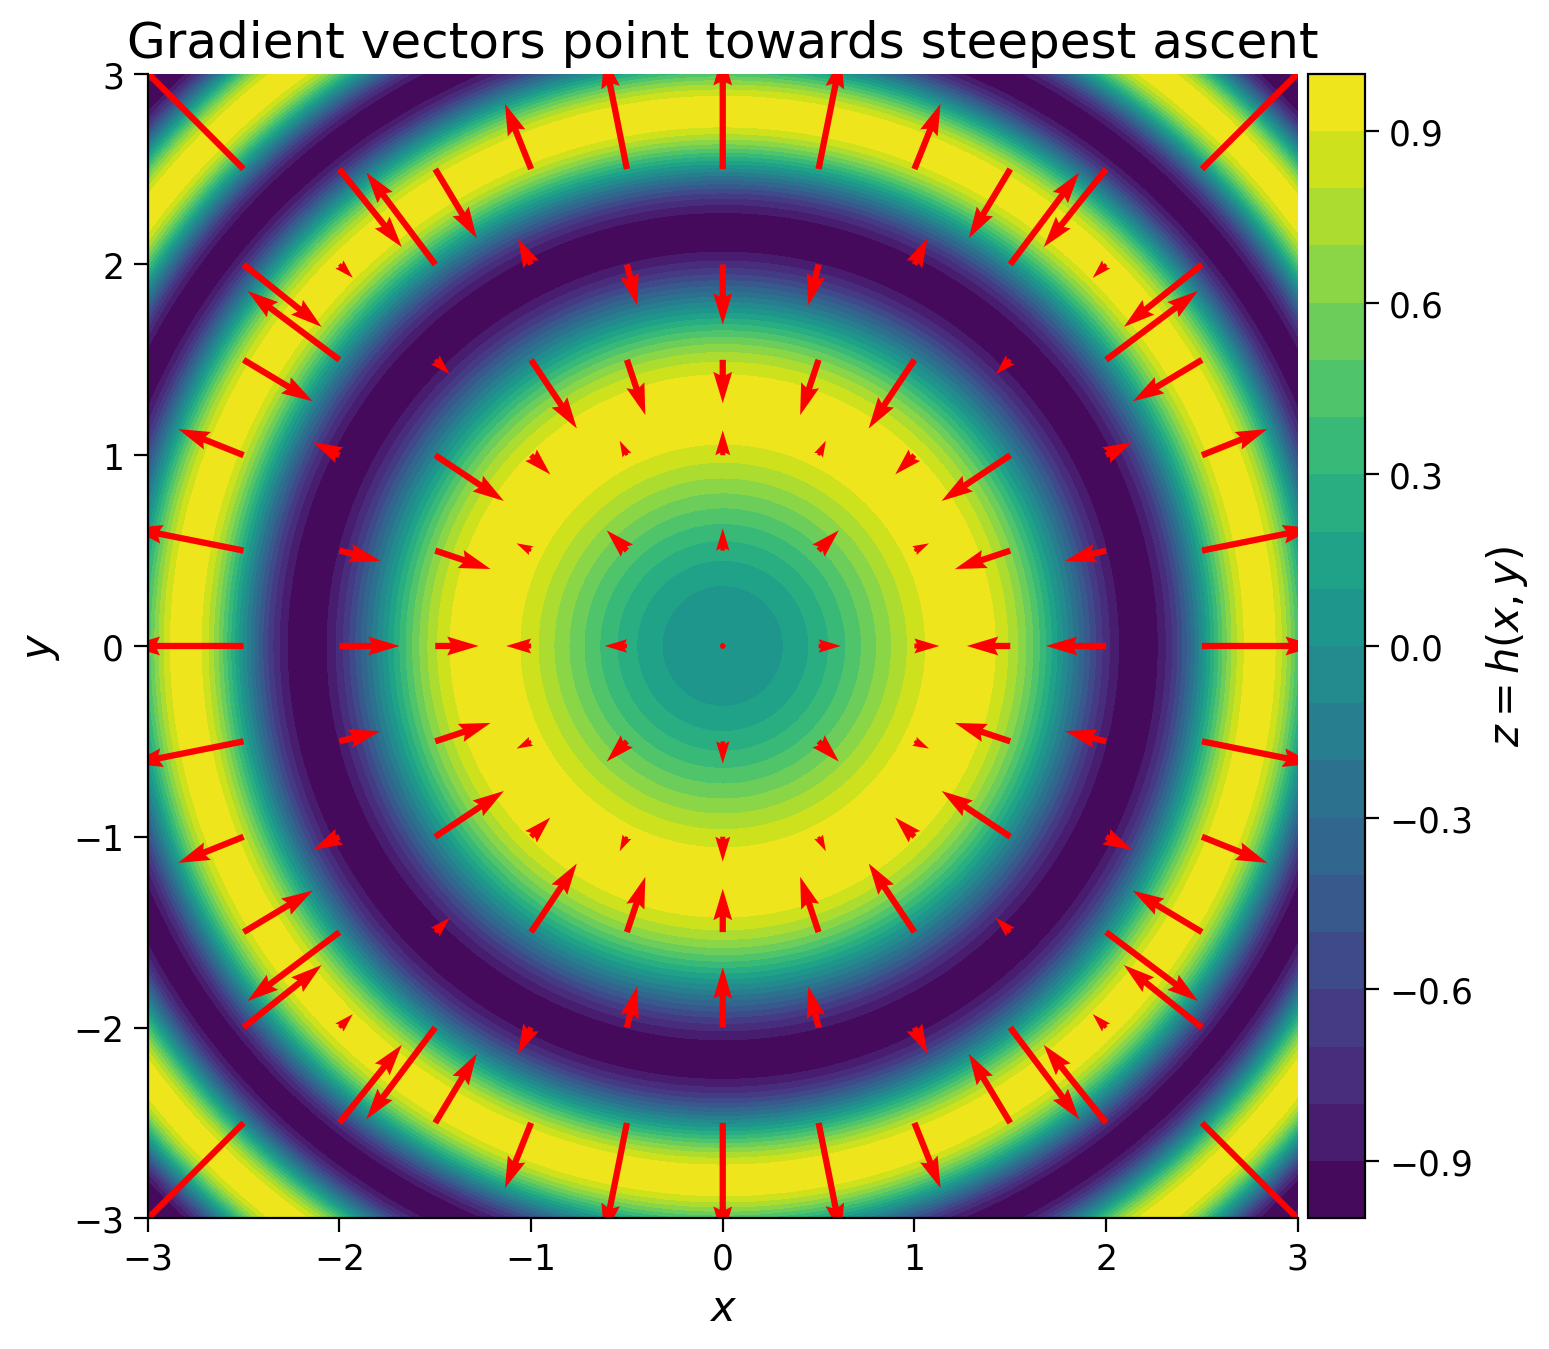

In [8]:
def fun_z(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    z: (float, np.ndarray)
      sin(x^2 + y^2)
  """
  z = np.sin(x**2 + y**2)
  return z

def fun_dz(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2CE = set_device()
  """
  dz_dx = 2 * x * np.cos(x**2 + y**2)
  dz_dy = 2 * y * np.cos(x**2 + y**2)
  return (dz_dx, dz_dy)

ex1_plot(fun_z, fun_dz)

In [9]:
class SimpleGraph:
  """
  Implementing Simple Computational Graph
  """

  def __init__(self, w, b):
    """
    Initializing the SimpleGraph

    Args:
      w: float
        Initial value for weight
      b: float
        Initial value for bias

    Returns:
      Nothing
    """
    assert isinstance(w, float)
    assert isinstance(b, float)
    self.w = torch.tensor([w], requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        1D tensor of features

    Returns:
      prediction: torch.Tensor
        Model predictions
    """
    assert isinstance(x, torch.Tensor)
    z = self.w * x + self.b
    prediction = torch.tanh(z)
    return prediction


def sq_loss(y_true, y_prediction):
  """
  L2 loss function

  Args:
    y_true: torch.Tensor
      1D tensor of target labels
    y_prediction: torch.Tensor
      1D tensor of predictions

  Returns:
    loss: torch.Tensor
      L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)

  loss = (y_true - y_prediction)**2
  return loss


feature = torch.tensor([1]) # Input tensor
target = torch.tensor([7])  # Target tensor

## Uncomment to run
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"Initial weight = {simple_graph.w.item()}, "
      f"\nInitial bias = {simple_graph.b.item()}")

prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")


Initial weight = -0.5, 
Initial bias = 0.5
for x=1 and y=7, prediction=0.0, and L2 Loss = 49.0


In [10]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a + b
print(f"Gradient function = {c.grad_fn}")

Gradient function = <AddBackward0 object at 0x7a594ace4580>


In [11]:
print(f"Gradient function for prediction = {prediction.grad_fn}")
print(f"Gradient function for loss       = {square_loss.grad_fn}")

Gradient function for prediction = <TanhBackward0 object at 0x7a587519b3a0>
Gradient function for loss       = <PowBackward0 object at 0x7a594ace52a0>


In [12]:
# Analytical gradients (Remember detaching)
ana_dloss_dw = -2 * feature * (target - prediction.detach())* (1 - prediction.detach()**2)
ana_dloss_db = -2 * (target - prediction.detach()) * (1 - prediction.detach()**2)

square_loss.backward()  # First we should callt he backward to build the graph
autograd_dloss_dw = simple_graph.w.grad # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([True])
tensor([True])


## Section 3.1: Training loop in PyTorch

We use a regression problem to study the training loop in PyTorch. The task is to train a wide nonlinear (using tanh activation function) neural net for a simple sin regression task. Wide neural networks are thought to be really good at generalisation.

### Generate the sample dataset

Random seed 2021 has been set.


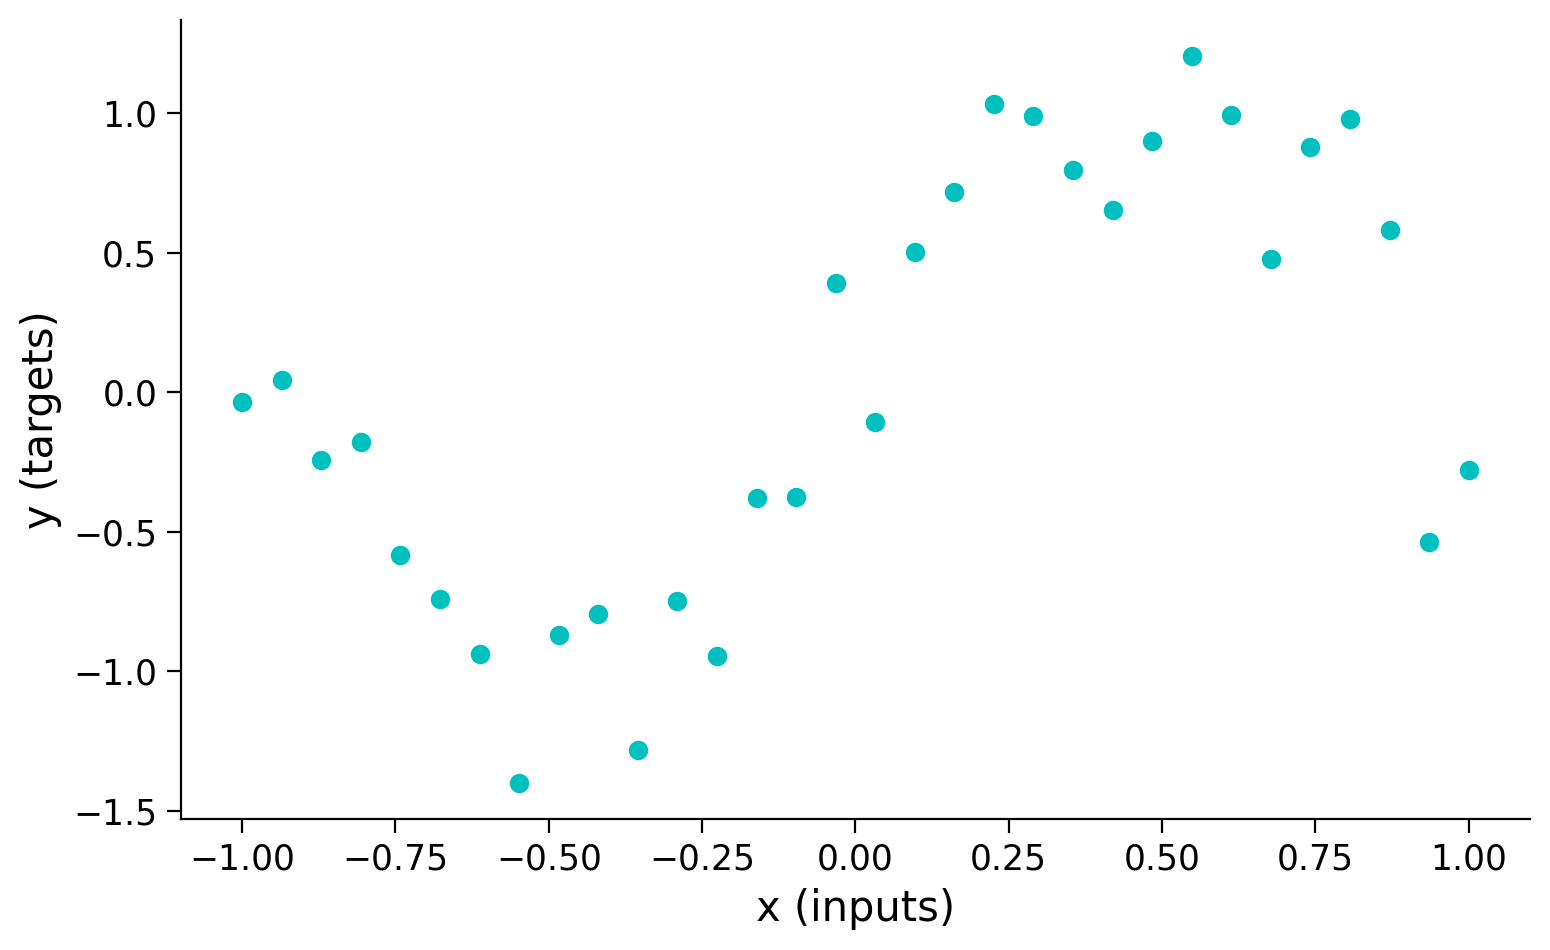

In [13]:
set_seed(seed=SEED)
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Let's define a very wide (512 neurons) neural net with one hidden layer and `nn.Tanh()` activation.

In [14]:
class WideNet(nn.Module):
  """
  A Wide neural network with a single hidden layer
  Structure is as follows:
  nn.Sequential(
    nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
    nn.Linear(n_cells, 1) # Finall fully connected layer
  )
  """
  def __init__(self, n_cells=512):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells),
        nn.Tanh(),
        nn.Linear(n_cells, 1)
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

We can now create an instance of our neural net and print its parameters.

In [15]:
# Creating an instance
set_seed(seed=SEED)
wide_net = WideNet()
print(wide_net)

Random seed 2021 has been set.
WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [16]:
# Create a mse loss function.
loss_function = nn.MSELoss()

# Stochastic Gradient Descent optimizer (you will learn about momentum soon)
lr = 0.003 # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

The training process in PyTorch is interactive - you can perform training iterations as you wish and inspect the results after each iteration.

Let's perform one training iteration. You can run the cell multiple times and see how the parameters are being updated and the loss is reducing. This code block is the core of everything to come: please make sure you go line-by-line through all the commands and discuss their purpose with your pod.

In [17]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

Loss: 0.8889423608779907


Random seed 2021 has been set.


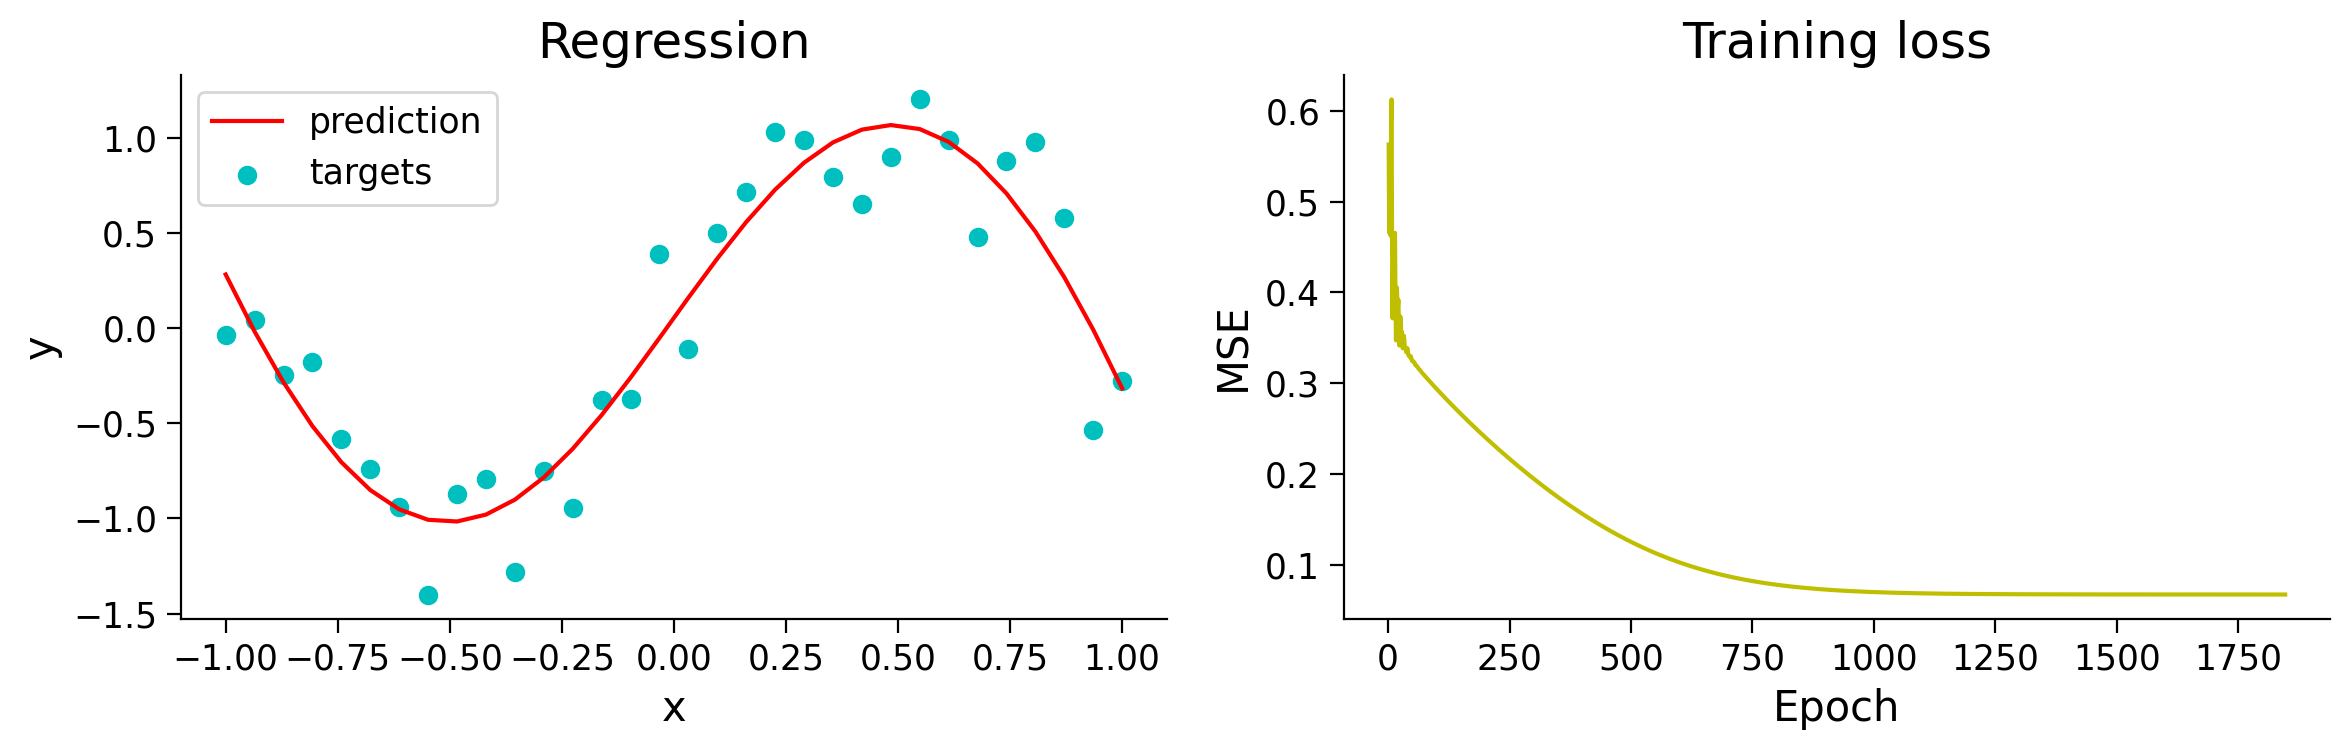

In [18]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
  """
  Training function

  Args:
    features: torch.Tensor
      Features (input) with shape torch.Size([n_samples, 1])
    labels: torch.Tensor
      Labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      The neural network
    loss_fun: function
      Loss function
    optimizer: function
      Optimizer
    n_epochs: int
      Number of training iterations

  Returns:
    loss_record: list
      Record (evolution) of training losses
  """
  loss_record = []  # keeping records of loss

  for i in range(n_epochs):
    # Set gradients to zero
    optimizer.zero_grad()
    predictions = model(features) # Compute model prediction (output)
    loss = loss_fun(predictions, labels) # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    optimizer.step() # Update parameters (optimizer takes a step)

    loss_record.append(loss.item()) # Keep record of the loss for this epoch

  return loss_record


set_seed(seed=2021)
epochs = 1847 # Cauch, Exercise d'analyse de physique mathematique (1847)
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
ex3_plot(wide_net, inputs, targets, epochs, losses)

Random seed 2021 has been set.


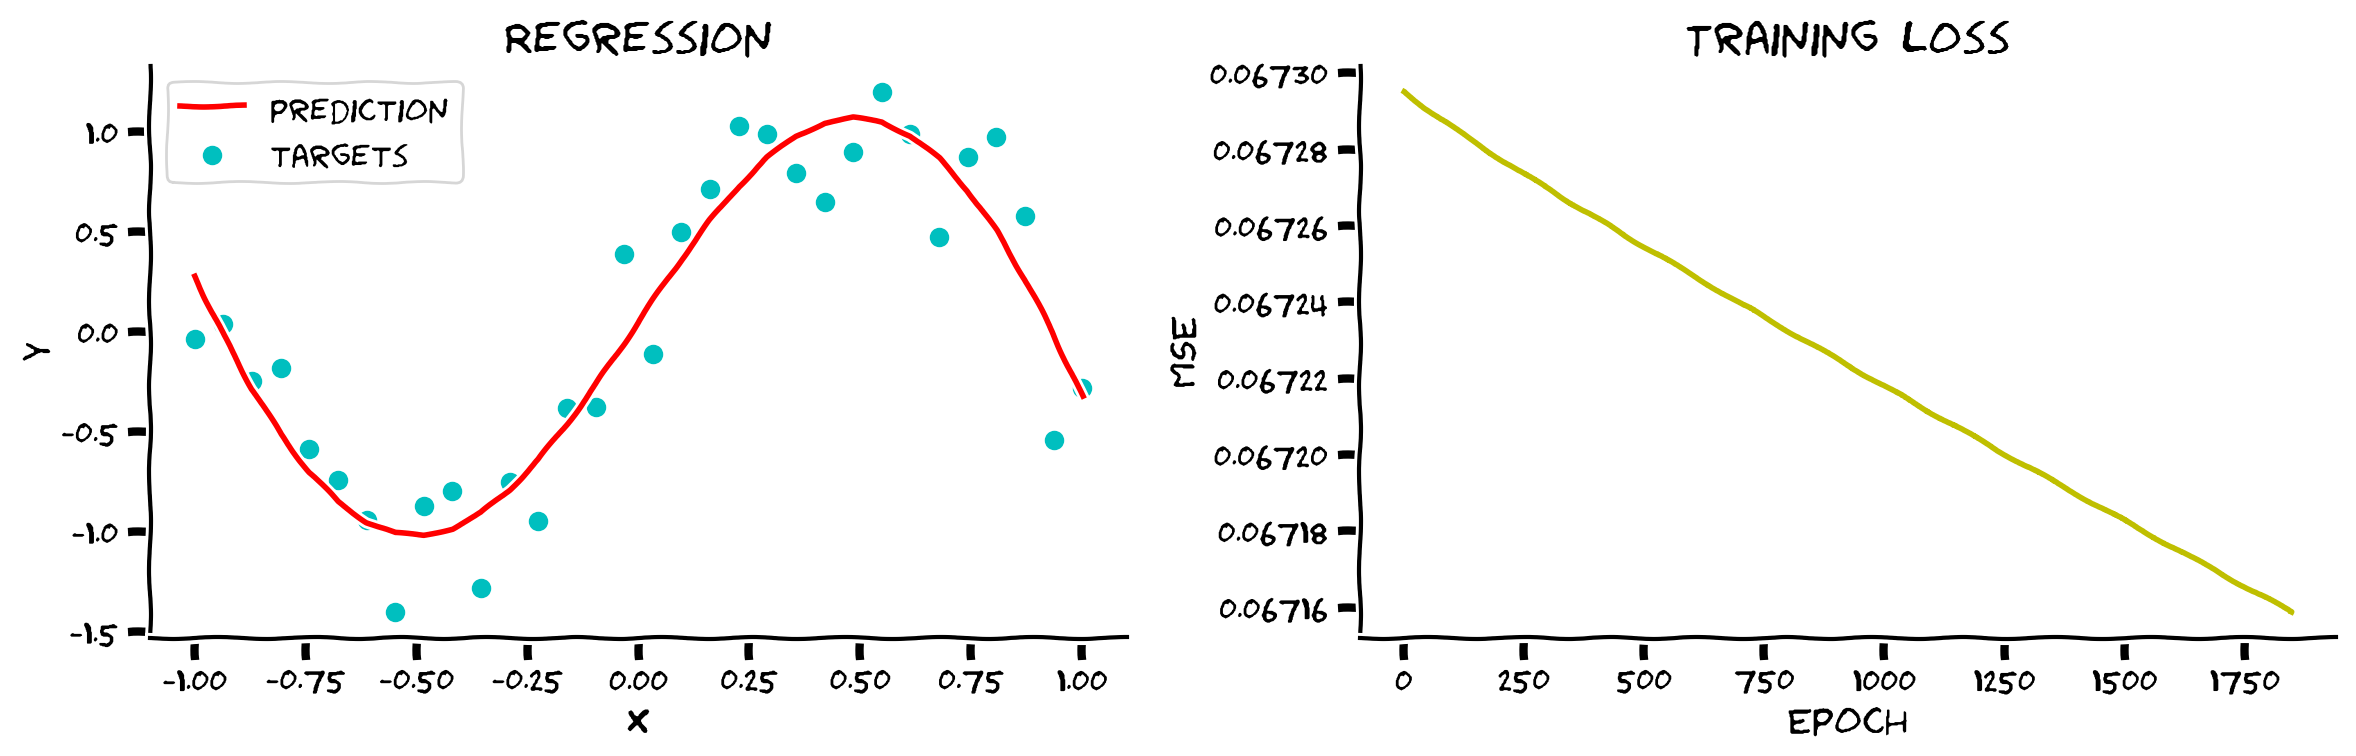

In [19]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
  """
  Training function

  Args:
    features: torch.Tensor
      Features (input) with shape torch.Size([n_samples, 1])
    labels: torch.Tensor
      Labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      The neural network
    loss_fun: function
      Loss function
    optimizer: function
      Optimizer
    n_epochs: int
      Number of training iterations

  Returns:
    loss_record: list
      Record (evolution) of training losses
  """
  loss_record = []  # Keeping recods of loss

  for i in range(n_epochs):
    optimizer.zero_grad()  # Set gradients to 0
    predictions = model(features)  # Compute model prediction (output)
    loss = loss_fun(predictions, labels)  # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    optimizer.step()  # Update parameters (optimizer takes a step)

    loss_record.append(loss.item())
  return loss_record



set_seed(seed=2021)
epochs = 1847 # Cauchy, Exercices d'analyse et de physique mathematique (1847)
## Uncomment to run
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
with plt.xkcd():
  ex3_plot(wide_net, inputs, targets, epochs, losses)

In [20]:
# @title Install and import feedback gadget
!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
      "", # No text prompt
      notebook_section,
      {
          "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
          "name": "neuromatch_dl",
          "user_key": "f379rz8y"
      }
  ).render()

feedback_prefix = "W1D2_T2"


In [21]:
# Imports
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [22]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import HBox, interactive_output, ToggleButton, Layout
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [23]:
# @title Plotting functions

# @title Plotting functions

def plot_x_y_(x_t_, y_t_, x_ev_, y_ev_, loss_log_, weight_log_):
  """
  Plot train data and test results

  Args:
  x_t_: np.ndarray
    Training dataset
  y_t_: np.ndarray
    Ground truth corresponding to training dataset
  x_ev_: np.ndarray
    Evaluation set
  y_ev_: np.ndarray
    ShallowNarrowNet predictions
  loss_log_: list
    Training loss records
  weight_log_: list
    Training weight records (evolution of weights)

  Returns:
    Nothing
  """
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.scatter(x_t_, y_t_, c='r', label='training data')
  plt.plot(x_ev_, y_ev_, c='b', label='test results', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.plot(loss_log_, c='r')
  plt.xlabel('epochs')
  plt.ylabel('mean squared error')
  plt.subplot(1, 3, 3)
  plt.plot(weight_log_)
  plt.xlabel('epochs')
  plt.ylabel('weights')
  plt.show()


def plot_vector_field(what, init_weights=None):
  """
  Helper function to plot vector fields

  Args:
    what: string
      If "all", plot vectors, trajectories and loss function
      If "vectors", plot vectors
      If "trajectory", plot trajectories
      If "loss", plot loss function

  Returns:
    Nothing
  """
  n_epochs=40
  lr=0.15
  x_pos = np.linspace(2.0, 0.5, 100, endpoint=True)
  y_pos = 1. / x_pos
  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  cmap = matplotlib.cm.plasma
  plt.figure(figsize=(8, 7))
  ax = plt.gca()

  if what == 'all' or what == 'vectors':
    for i, a in enumerate(x):
      for j, b in enumerate(y):
        temp_model = ShallowNarrowLNN([a, b])
        da, db = temp_model.dloss_dw(x_temp, y_temp)
        zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)
        scale = min(40 * np.sqrt(da**2 + db**2), 50)
        ax.quiver(a, b, - da, - db, scale=scale, color=cmap(np.sqrt(da**2 + db**2)))

  if what == 'all' or what == 'trajectory':
    if init_weights is None:
      for init_weights in [[0.5, -0.5], [0.55, -0.45], [-1.8, 1.7]]:
        temp_model = ShallowNarrowLNN(init_weights)
        _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
        ax.scatter(temp_records[:, 0], temp_records[:, 1],
                    c=np.arange(len(temp_records)), cmap='Greys')
        ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
        ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)
    else:
      temp_model = ShallowNarrowLNN(init_weights)
      _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
      ax.scatter(temp_records[:, 0], temp_records[:, 1],
                  c=np.arange(len(temp_records)), cmap='Greys')
      ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
      ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)

  if what == 'all' or what == 'loss':
    contplt = ax.contourf(x, y, np.log(zz+0.001), zorder=-1, cmap='coolwarm', levels=100)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contplt, cax=cax)
    cbar.set_label('log (Loss)')

  ax.set_xlabel("$w_1$")
  ax.set_ylabel("$w_2$")
  ax.set_xlim(-1.9, 1.9)
  ax.set_ylim(-1.9, 1.9)

  plt.show()


def plot_loss_landscape():
  """
  Helper function to plot loss landscapes

  Args:
    None

  Returns:
    Nothing
  """
  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  for i, a in enumerate(x):
    for j, b in enumerate(y):
      temp_model = ShallowNarrowLNN([a, b])
      zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)

  temp_model = ShallowNarrowLNN([-1.8, 1.7])
  loss_rec_1, w_rec_1 = temp_model.train(x_temp, y_temp, 0.02, 240)

  temp_model = ShallowNarrowLNN([1.5, -1.5])
  loss_rec_2, w_rec_2 = temp_model.train(x_temp, y_temp, 0.02, 240)

  plt.figure(figsize=(12, 8))
  ax = plt.subplot(1, 1, 1, projection='3d')
  ax.plot_surface(xx, yy, np.log(zz+0.5), cmap='coolwarm', alpha=0.5)
  ax.scatter3D(w_rec_1[:, 0], w_rec_1[:, 1], np.log(loss_rec_1+0.5),
                c='k', s=50, zorder=9)
  ax.scatter3D(w_rec_2[:, 0], w_rec_2[:, 1], np.log(loss_rec_2+0.5),
                c='k', s=50, zorder=9)
  plt.axis("off")
  ax.view_init(45, 260)

  plt.show()


def depth_widget(depth):
  """
  Simulate parameter in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network

  Returns:
    Nothing
  """
  if depth == 0:
    depth_lr_init_interplay(depth, 0.02, 0.9)
  else:
    depth_lr_init_interplay(depth, 0.01, 0.9)


def lr_widget(lr):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    lr: float
      Specifies learning rate within network

  Returns:
    Nothing
  """
  depth_lr_init_interplay(50, lr, 0.9)


def depth_lr_interplay(depth, lr):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network
    lr: float
      Specifies learning rate within network

  Returns:
    Nothing
  """
  depth_lr_init_interplay(depth, lr, 0.9)


def depth_lr_init_interplay(depth, lr, init_weights):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network
    lr: float
      Specifies learning rate within network
    init_weights: list
      Specifies initial weights of the network

  Returns:
    Nothing
  """
  n_epochs = 600

  x_train, y_train = gen_samples(100, 2.0, 0.1)
  model = DeepNarrowLNN(np.full((1, depth+1), init_weights))

  plt.figure(figsize=(10, 5))
  plt.plot(model.train(x_train, y_train, lr, n_epochs),
            linewidth=3.0, c='m')

  plt.title("Training a {}-layer LNN with"
  " $\eta=${} initialized with $w_i=${}".format(depth, lr, init_weights), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.ylim(0.001, 1.0)
  plt.show()


def plot_init_effect():
  """
  Helper function to plot evolution of log mean
  squared error over epochs

  Args:
    None

  Returns:
    Nothing
  """
  depth = 15
  n_epochs = 250
  lr = 0.02

  x_train, y_train = gen_samples(100, 2.0, 0.1)

  plt.figure(figsize=(12, 6))
  for init_w in np.arange(0.7, 1.09, 0.05):
      model = DeepNarrowLNN(np.full((1, depth), init_w))
      plt.plot(model.train(x_train, y_train, lr, n_epochs),
              linewidth=3.0, label="initial weights {:.2f}".format(init_w))
  plt.title("Training a {}-layer narrow LNN with $\eta=${}".format(depth, lr), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.legend(loc='lower left', ncol=4)
  plt.ylim(0.001, 1.0)
  plt.show()


class InterPlay:
  """
  Class specifying parameters for widget
  exploring relationship between the depth
  and optimal learning rate
  """

  def __init__(self):
    """
    Initialize parameters for InterPlay

    Args:
      None

    Returns:
      Nothing
    """
    self.lr = [None]
    self.depth = [None]
    self.success = [None]
    self.min_depth, self.max_depth = 5, 65
    self.depth_list = np.arange(10, 61, 10)
    self.i_depth = 0
    self.min_lr, self.max_lr = 0.001, 0.105
    self.n_epochs = 600
    self.x_train, self.y_train = gen_samples(100, 2.0, 0.1)
    self.converged = False
    self.button = None
    self.slider = None

  def train(self, lr, update=False, init_weights=0.9):
    """
    Train network associated with InterPlay

    Args:
      lr: float
        Specifies learning rate within network
      init_weights: float
        Specifies initial weights of the network [default: 0.9]
      update: boolean
        If true, show updates on widget

    Returns:
      Nothing
    """
    if update and self.converged and self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      self.plot(depth, lr)
      self.i_depth += 1
      self.lr.append(None)
      self.depth.append(None)
      self.success.append(None)
      self.converged = False
      self.slider.value = 0.005
      if self.i_depth < len(self.depth_list):
        self.button.value = False
        self.button.description = 'Explore!'
        self.button.disabled = True
        self.button.button_style = 'Danger'
      else:
        self.button.value = False
        self.button.button_style = ''
        self.button.disabled = True
        self.button.description = 'Done!'
      time.sleep(1.0)

    elif self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      # Additional assert: self.min_depth <= depth <= self.max_depth
      assert self.min_lr <= lr <= self.max_lr
      self.converged = False

      model = DeepNarrowLNN(np.full((1, depth), init_weights))
      self.losses = np.array(model.train(self.x_train, self.y_train, lr, self.n_epochs))
      if np.any(self.losses < 1e-2):
        success = np.argwhere(self.losses < 1e-2)[0][0]
        if np.all((self.losses[success:] < 1e-2)):
          self.converged = True
          self.success[-1] = success
          self.lr[-1] = lr
          self.depth[-1] = depth
          self.button.disabled = False
          self.button.button_style = 'Success'
          self.button.description = 'Register!'
        else:
          self.button.disabled = True
          self.button.button_style = 'Danger'
          self.button.description = 'Explore!'
      else:
        self.button.disabled = True
        self.button.button_style = 'Danger'
        self.button.description = 'Explore!'
      self.plot(depth, lr)

  def plot(self, depth, lr):
    """
    Plot following subplots:
    a. Log mean squared error vs Epochs
    b. Learning time vs Depth
    c. Optimal learning rate vs Depth

    Args:
      depth: int
        Specifies depth of network
      lr: float
        Specifies learning rate of network

    Returns:
      Nothing
    """
    fig = plt.figure(constrained_layout=False, figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax1.plot(self.losses, linewidth=3.0, c='m')
    ax1.set_title("Training a {}-layer LNN with"
    " $\eta=${}".format(depth, lr), pad=15, fontsize=16)
    ax1.set_yscale('log')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Log mean squared error')
    ax1.set_ylim(0.001, 1.0)

    ax2.set_xlim(self.min_depth, self.max_depth)
    ax2.set_ylim(-10, self.n_epochs)
    ax2.set_xlabel('Depth')
    ax2.set_ylabel('Learning time (Epochs)')
    ax2.set_title("Learning time vs depth", fontsize=14)
    ax2.scatter(np.array(self.depth), np.array(self.success), c='r')

    ax3.set_xlim(self.min_depth, self.max_depth)
    ax3.set_ylim(self.min_lr, self.max_lr)
    ax3.set_xlabel('Depth')
    ax3.set_ylabel('Optimal learning rate')
    ax3.set_title("Empirically optimal $\eta$ vs depth", fontsize=14)
    ax3.scatter(np.array(self.depth), np.array(self.lr), c='r')

    plt.show()

In [24]:
# @title Helper functions

def gen_samples(n, a, sigma):
  """
  Generates n samples with
  `y = z * x + noise(sigma)` linear relation.

  Args:
    n : int
      Number of datapoints within sample
    a : float
      Offset of x
    sigma : float
      Standard deviation of distribution

  Returns:
    x : np.ndarray
      if sigma > 0, x = random values
      else, x = evenly spaced numbers over a specified interval.
    y : np.ndarray
      y = z * x + noise(sigma)
  """
  assert n > 0
  assert sigma >= 0

  if sigma > 0:
    x = np.random.rand(n)
    noise = np.random.normal(scale=sigma, size=(n))
    y = a * x + noise
  else:
    x = np.linspace(0.0, 1.0, n, endpoint=True)
    y = a * x

  return x, y


class ShallowNarrowLNN:
  """
  Shallow and narrow (one neuron per layer)
  linear neural network
  """
  def __init__(self, init_ws):
    """
    Initialise parameters of ShallowNarrowLNN

    Args:
      init_ws: initial weights as a list

    Returns:
      Nothing
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]

  def forward(self, x):
    """
    The forward pass through network y = x * w1 * w2

    Args:
      x : np.ndarray
        Input data

    Returns:
      y : np.ndarray
        y = x * w1 * w2

    """
    y = x * self.w1 * self.w2
    return y

  def loss(self, y_p, y_t):
    """
    Mean squared error (L2)
    with 1/2 for convenience

    Args:
      y_p : np.ndarray
        Network Predictions
      y_t : np.ndarray
        Targets

    Returns:
      mse : float
        Average mean squared error
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2).mean()
    return mse

  def dloss_dw(self, x, y_t):
    """
    Partial derivative of loss with respect to weights

    Args:
      x : np.ndarray
        Input Dataset
      y_t : np.ndarray
        Corresponding Ground Truth

    Returns:
      dloss_dw1 : float
        -mean(2 * self.w2 * x * Error)
      dloss_dw2 : float
        -mean(2 * self.w1 * x * Error)
    """
    assert x.shape == y_t.shape
    Error = y_t - self.w1 * self.w2 * x
    dloss_dw1 = - (2 * self.w2 * x * Error).mean()
    dloss_dw2 = - (2 * self.w1 * x * Error).mean()
    return dloss_dw1, dloss_dw2

  def train(self, x, y_t, eta, n_ep):
    """
    Gradient descent algorithm

    Args:
      x : np.ndarray
        Input Dataset
      y_t : np.ndarray
        Corresponding target
      eta : float
        Learning rate
      n_ep : int
        Number of epochs

    Returns:
      loss_records : np.ndarray
        Log of loss per epoch
      weight_records : np.ndarray
        Log of weights per epoch
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep) # Pre allocation of loss records
    weight_records = np.empty((n_ep, 2)) # Pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      self.w1 -= eta * dloss_dw1
      self.w2 -= eta * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


In [25]:
class DeepNarrowLNN:
  """
  Deep but thin (one neuron per layer)
  linear neural network
  """
  def __init__(self, init_ws):
    """
    Initialise parameters of DeepNarrowLNN

    Args:
      init_ws: np.ndarray
        Initial weights as a numpy array

    Returns:
      Nothing
    """
    self.n = init_ws.size
    self.W = init_ws.reshape(1, -1)

  def forward(self, x):
    """
    Forward pass of DeepNarrowLNN

    Args:
      x : np.ndarray
        Input features

    Returns:
      y : np.ndarray
        Product of weights over input features
    """
    y = np.prod(self.W) * x
    return y

  def loss(self, y_t, y_p):
    """
    Mean squared error (L2 loss)

    Args:
      y_t : np.ndarray
        Target
      y_p : np.ndarray
        Network's predictions

    Returns:
      mse : float
        Mean squared error
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2 / 2).mean()
    return mse

  def dloss_dw(self, x, y_t, y_p):
    """
    """
    E = y_t - y_p  # i.e., y_t - x * np.prod(self.W)
    Ex = np.multiply(x, E).mean()
    Wp = np.prod(self.W) / (self.W + 1e-9)
    dW = -Ex * Wp
    return dW

  def train(self, x, y_t, eta, n_epochs):
    """
    Training using gradient descent

    Args:
      x : np.ndarray
        Input features
      y_t : np.ndarray
        Targets
      eta : float
        Learning rate
      n_epochs : int
        Number of epochs

    Returns:
      loss_records : np.ndarray
        Log of loss over epochs
    """
    loss_records  = np.empty(n_epochs)
    loss_records[:] = np.nan
    for i in range(n_epochs):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_t, y_p).mean()
      dloss_dw = self.dloss_dw(x, y_t, y_p)
      if np.isnan(dloss_dw).any() or np.isinf(dloss_dw).any():
        return loss_records
      self.W -= eta * dloss_dw
    return loss_records


In [26]:
# @title Set random seed

# @markdown Executing `set_ssed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [27]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [28]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [29]:
class ShallowNarrowExercise:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """
  def __init__(self, init_weights):
    """
    Initialise parameters of ShallowNarrow Net

    Args:
      init_weights: list
        Initial weights

    Returns:
      Nothing
    """
    assert isinstance(init_weights, (list, np.ndarray, tuple))
    assert len(init_weights) == 2
    self.w1 = init_weights[0]
    self.w2 = init_weights[1]


  def forward(self, x):
    """
    The forward pass through network y = x * w1 * w2

    Args:
      x : np.ndarray
        Features (inputs) to neural net

    Returns
      y: np.ndarray
        Neural network output (predictions)
    """
    y = x * self.w1 * self.w2
    return y

  def dloss_dw(self, x, y_true):
    """
    Gradient of loss with respect to weights

    Args:
      x : np.ndarray
        Features (inputs) to neural net
      y_true: np.ndarray
        True labels

    Returns:
      dloss_dw1 : float
        Mean gradient of loss with respect to w1
      dloss_dw2 : float
        Mean gradient of loss with respect to w2
    """
    assert x.shape == y_true.shape

    dloss_dw1 = np.mean(-2*self.w2*x*(y_true - self.w1*self.w2*x))
    dloss_dw2 = np.mean(-2*self.w1*x*(y_true - self.w1*self.w2*x))

    return dloss_dw1, dloss_dw2

  def train(self, x, y_true, lr, n_ep):
    """
    Training with Gradient descent algorithm

    Args:
      x : np.ndarray
        Features (inputs) to neural net
      y_true: np.ndarray
        True labels
      lr : float
        Learning rate
      n_ep : int
        Number of epochs (training iterations)

     Returns:
      loss_records: list
        Training loss records
      weight_records: list
        Training weight records (evolution of weights)
    """
    assert x.shape == y_true.shape

    loss_records = np.empty(n_ep) # Pre allocation of loss records
    weight_records = np.empty((n_ep, 2)) # Pre allocation of weight records

    for i in range(n_ep):
      y_prediction = self.forward(x)
      loss_records[i] = loss(y_prediction, y_true)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_true)
      self.w1 -= lr * dloss_dw1
      self.w2 -= lr * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records

def loss(y_prediction, y_true):
  """
  Mean squared error

  Args:
    y_prediction : np.ndarray
      Model output (prediction)
    y_true : np.ndarray
      True label

  Returns:
    mse: np.ndarray
      Mean squared error loss
  """
  assert y_prediction.shape == y_true.shape
  mse = ((y_true - y_prediction)**2).mean()
  return mse

Random seed 2021 has been set.


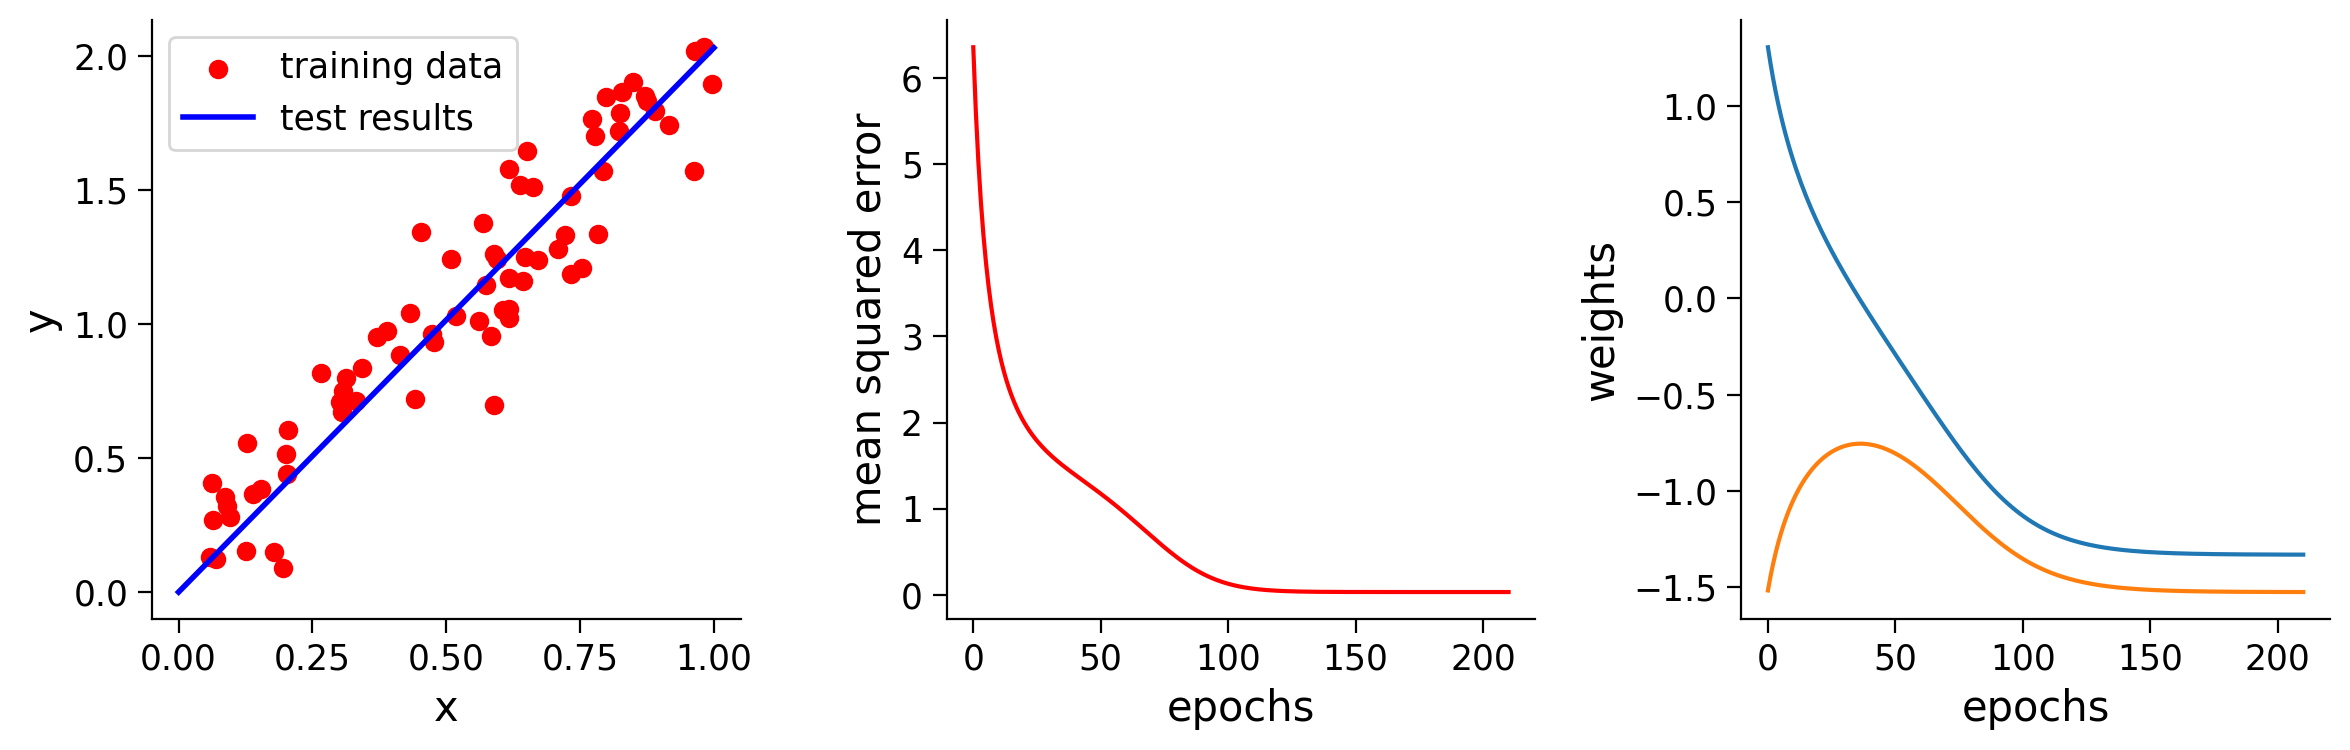

In [30]:
set_seed(seed=SEED)
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

sn_model = ShallowNarrowExercise(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)

plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

Random seed 2021 has been set.


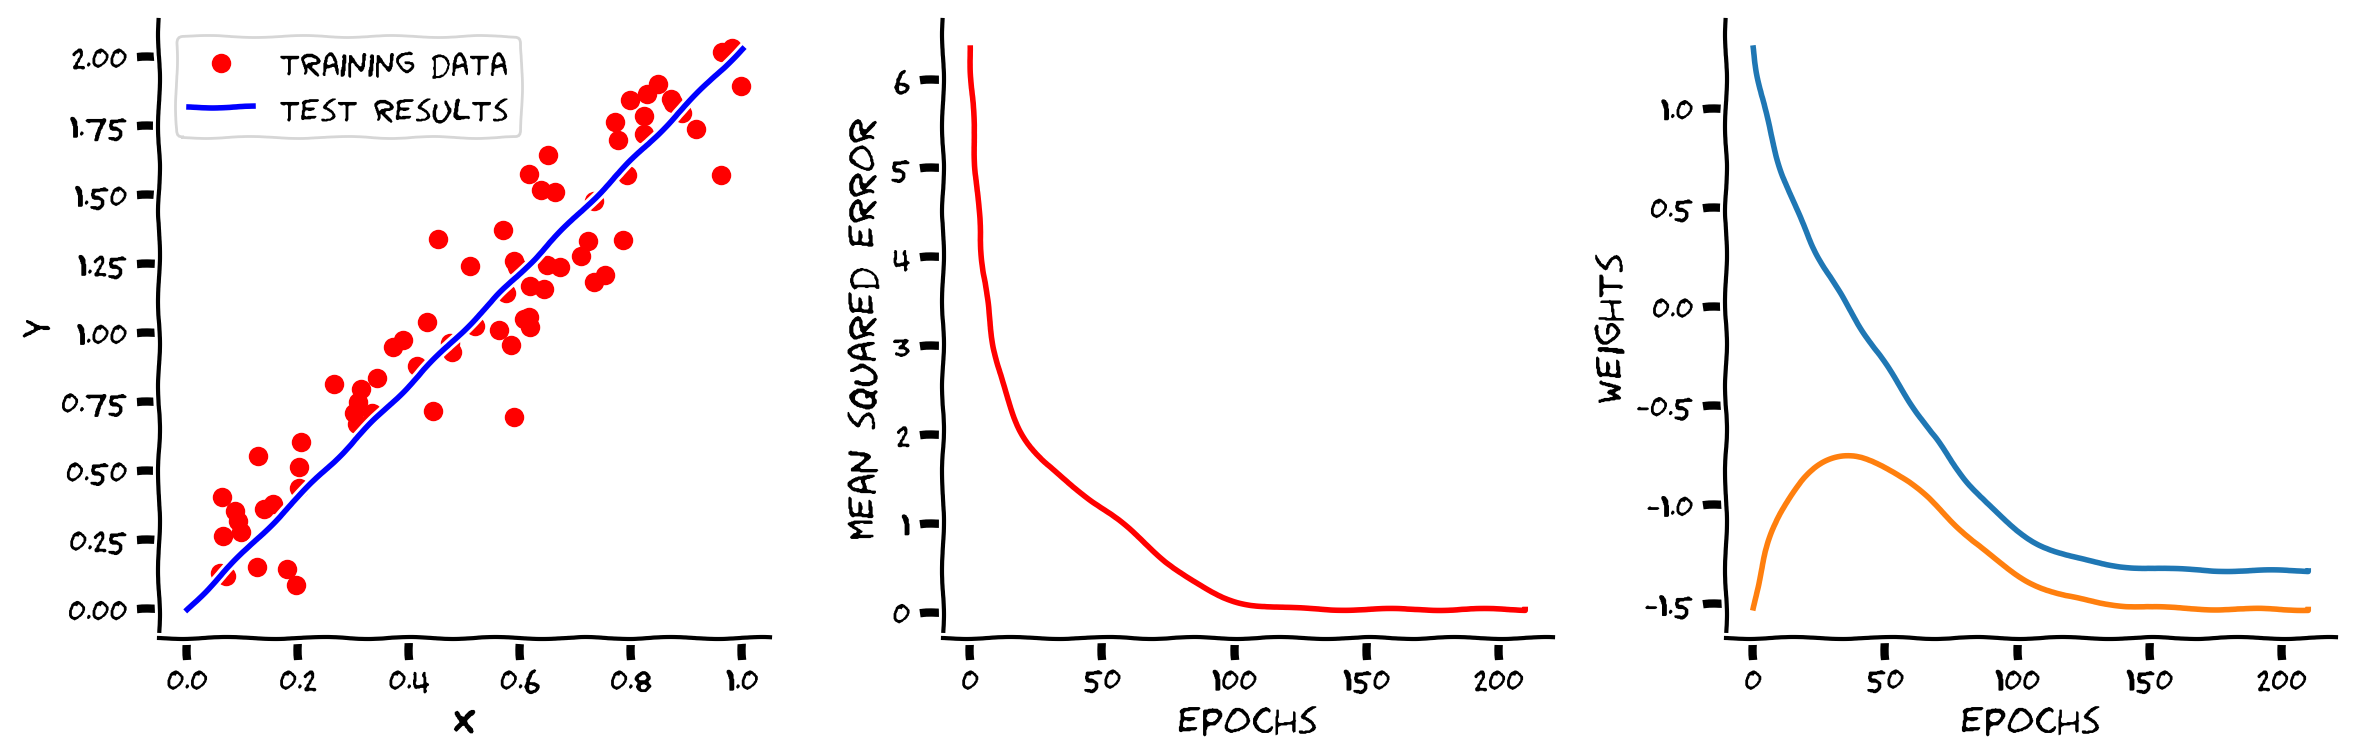

In [31]:
class ShallowNarrowExercise:
  """
  Shallow and narrow (one neuron per layer) linear neural network
  """

  def __init__(self, init_weights):
    """
    Initialize parameters of ShallowNarrow Net

    Args:
      init_weights: list
        Initial weights

    Returns:
      Nothing
    """
    assert isinstance(init_weights, (list, np.ndarray, tuple))
    assert len(init_weights) == 2
    self.w1 = init_weights[0]
    self.w2 = init_weights[1]


  def forward(self, x):
    """
    The forward pass through netwrok y = x * w1 * w2

    Args:
      x: np.ndarray
        Features (inputs) to neural net

    Returns:
      y: np.ndarray
        Neural network output (predictions)
    """
    y = x * self.w1 * self.w2
    return y


  def dloss_dw(self, x, y_true):
    """
    Gradient of loss with respect to weights

    Args:
      x: np.ndarray
        Features (inputs) to neural net
      y_true: np.ndarray
        True labels

    Returns:
      dloss_dw1: float
        Mean gradient of loss with respect to w1
      dloss_dw2: float
        Mean gradient of loss with respect to w2
    """
    assert x.shape == y_true.shape
    dloss_dw1 = - (2 * self.w2 * x * (y_true - self.w1 * self.w2 * x)).mean()
    dloss_dw2 = - (2 * self.w1 * x * (y_true - self.w1 * self.w2 * x)).mean()
    return dloss_dw1, dloss_dw2


  def train(self, x, y_true, lr, n_ep):
    """
    Training with Gradient descent algorithm

    Args:
      x: np.ndarray
        Features (inputs) to neural net
      y_true: np.ndarray
        True labels
      lr: float
        Learning rate
      n_ep: int
        Number of epochs (training iterations)

    Returns:
      loss_records: list
        Training loss records
      weight_records: list
        Training weight records (evolution of weights)
    """
    assert x.shape == y_true.shape

    loss_records = np.empty(n_ep)  # Pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # Pre allocation of weight records

    for i in range(n_ep):
      y_prediction = self.forward(x)
      loss_records[i] = loss(y_prediction, y_true)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_true)
      self.w1 -= lr * dloss_dw1
      self.w2 -= lr * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


def loss(y_prediction, y_true):
  """
  Mean squared error

  Args:
    y_prediction: np.ndarray
      Model output (prediction)
    y_true: np.ndarray
      True label

  Returns:
    mse: np.ndarray
      Mean squared error loss
  """
  assert y_prediction.shape == y_true.shape
  mse = ((y_true - y_prediction)**2).mean()
  return mse



set_seed(seed=SEED)
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)
## Uncomment to run
sn_model = ShallowNarrowExercise(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)
with plt.xkcd():
  plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

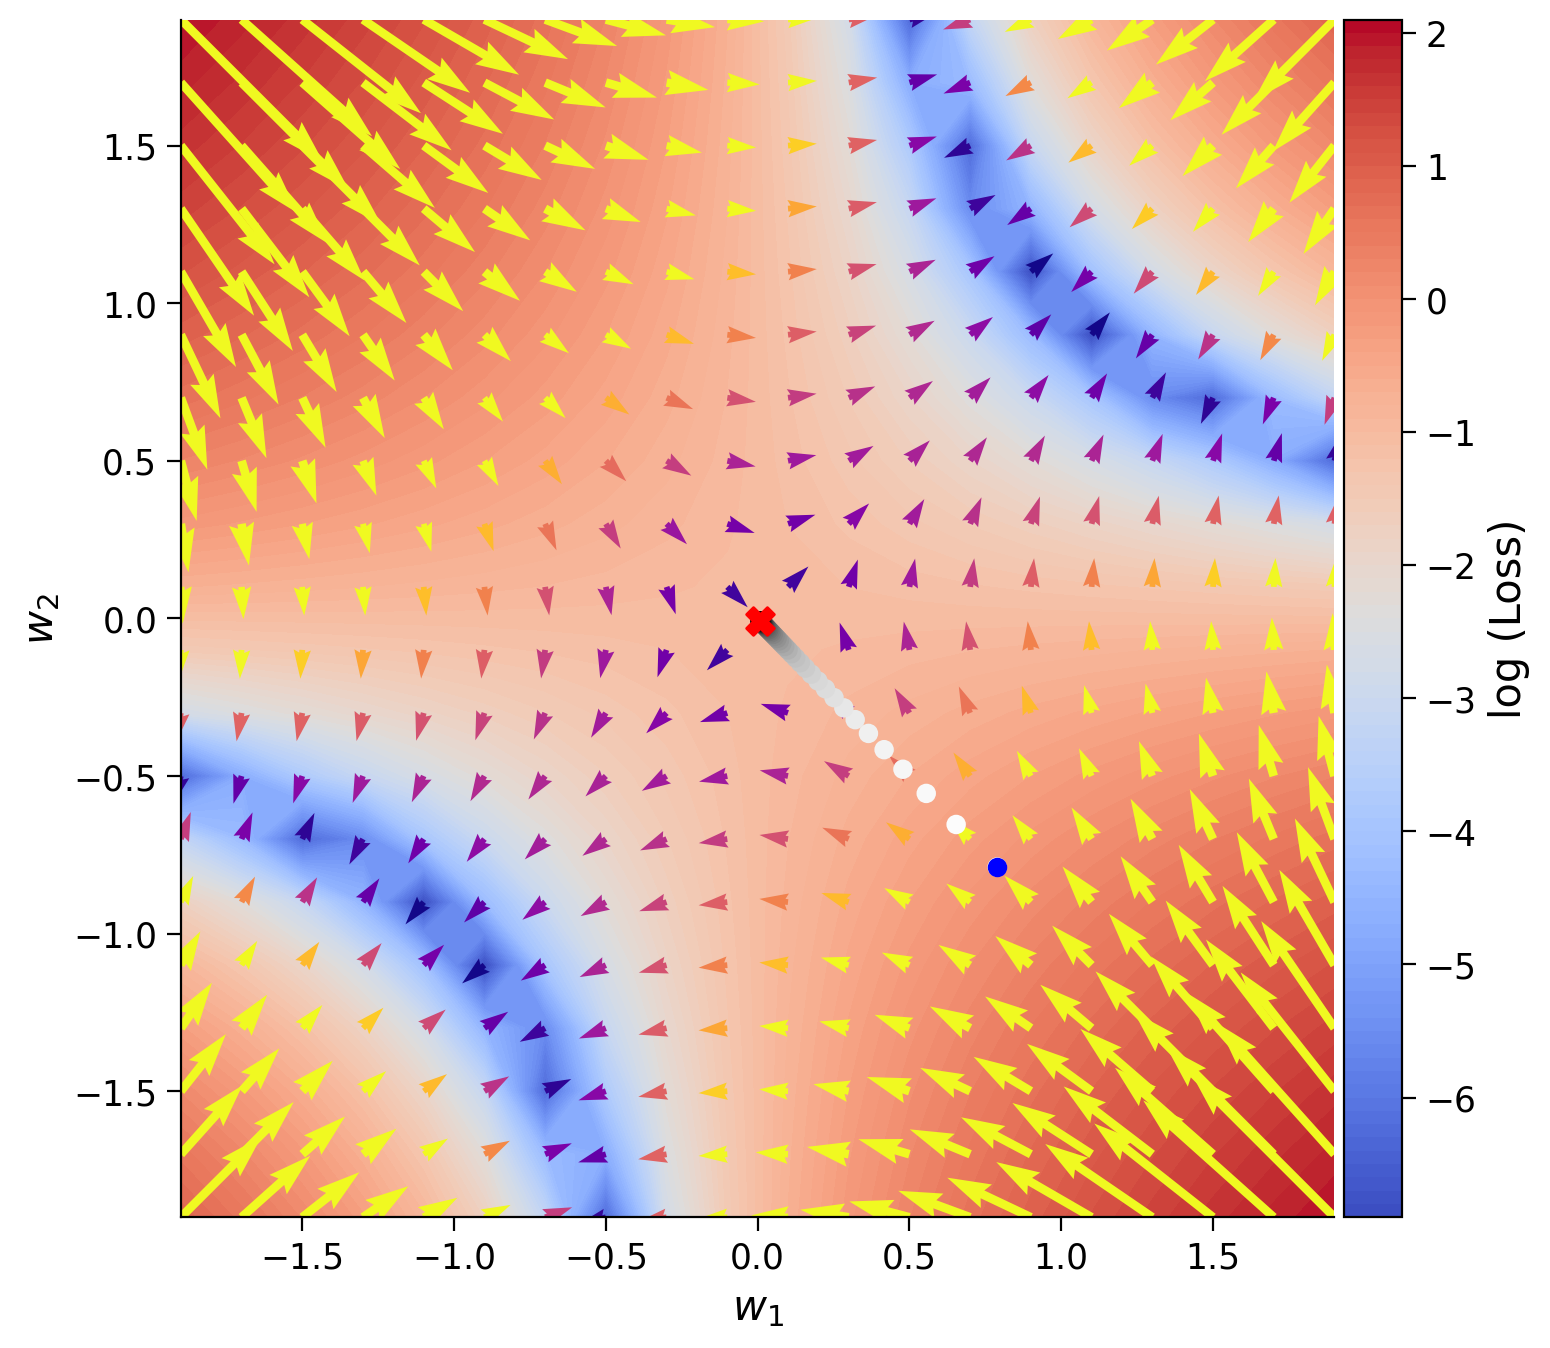

In [32]:
plot_vector_field('all', [1.0, -1.0])

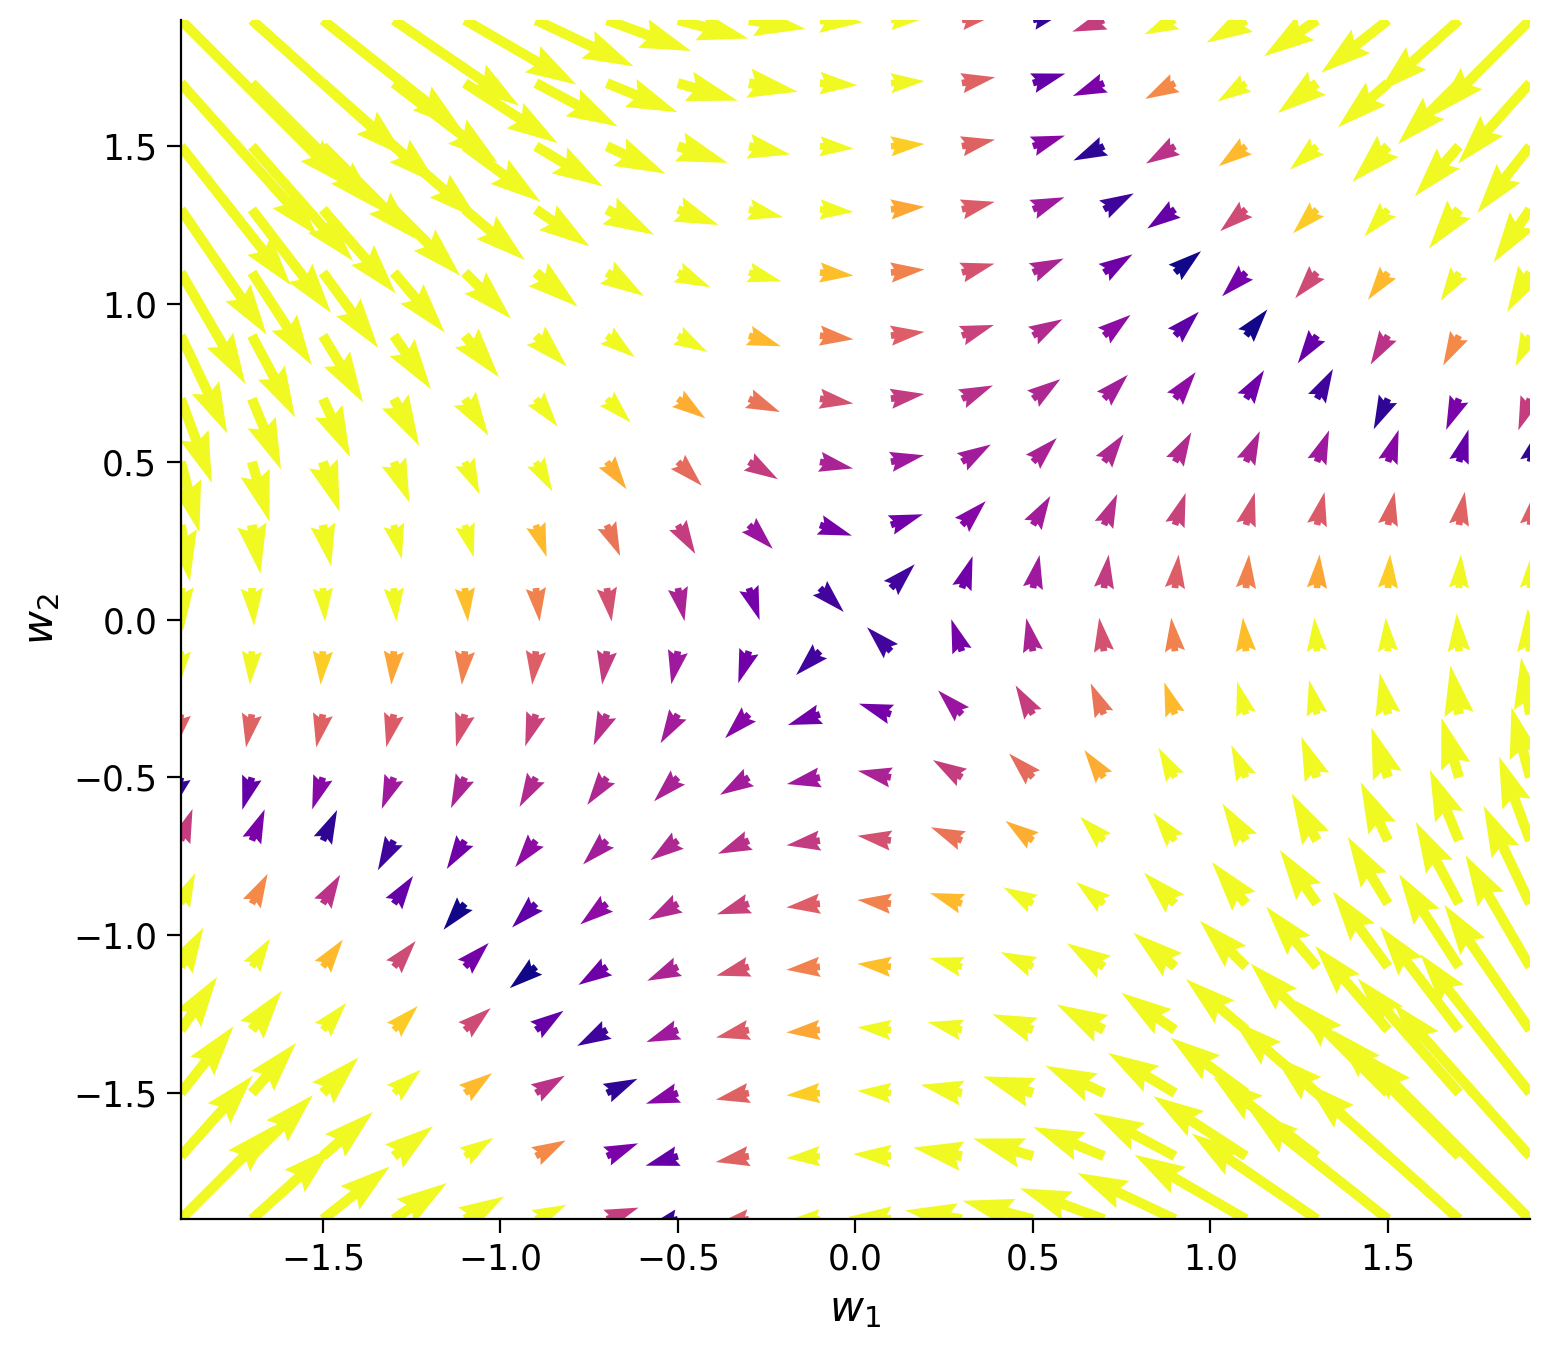

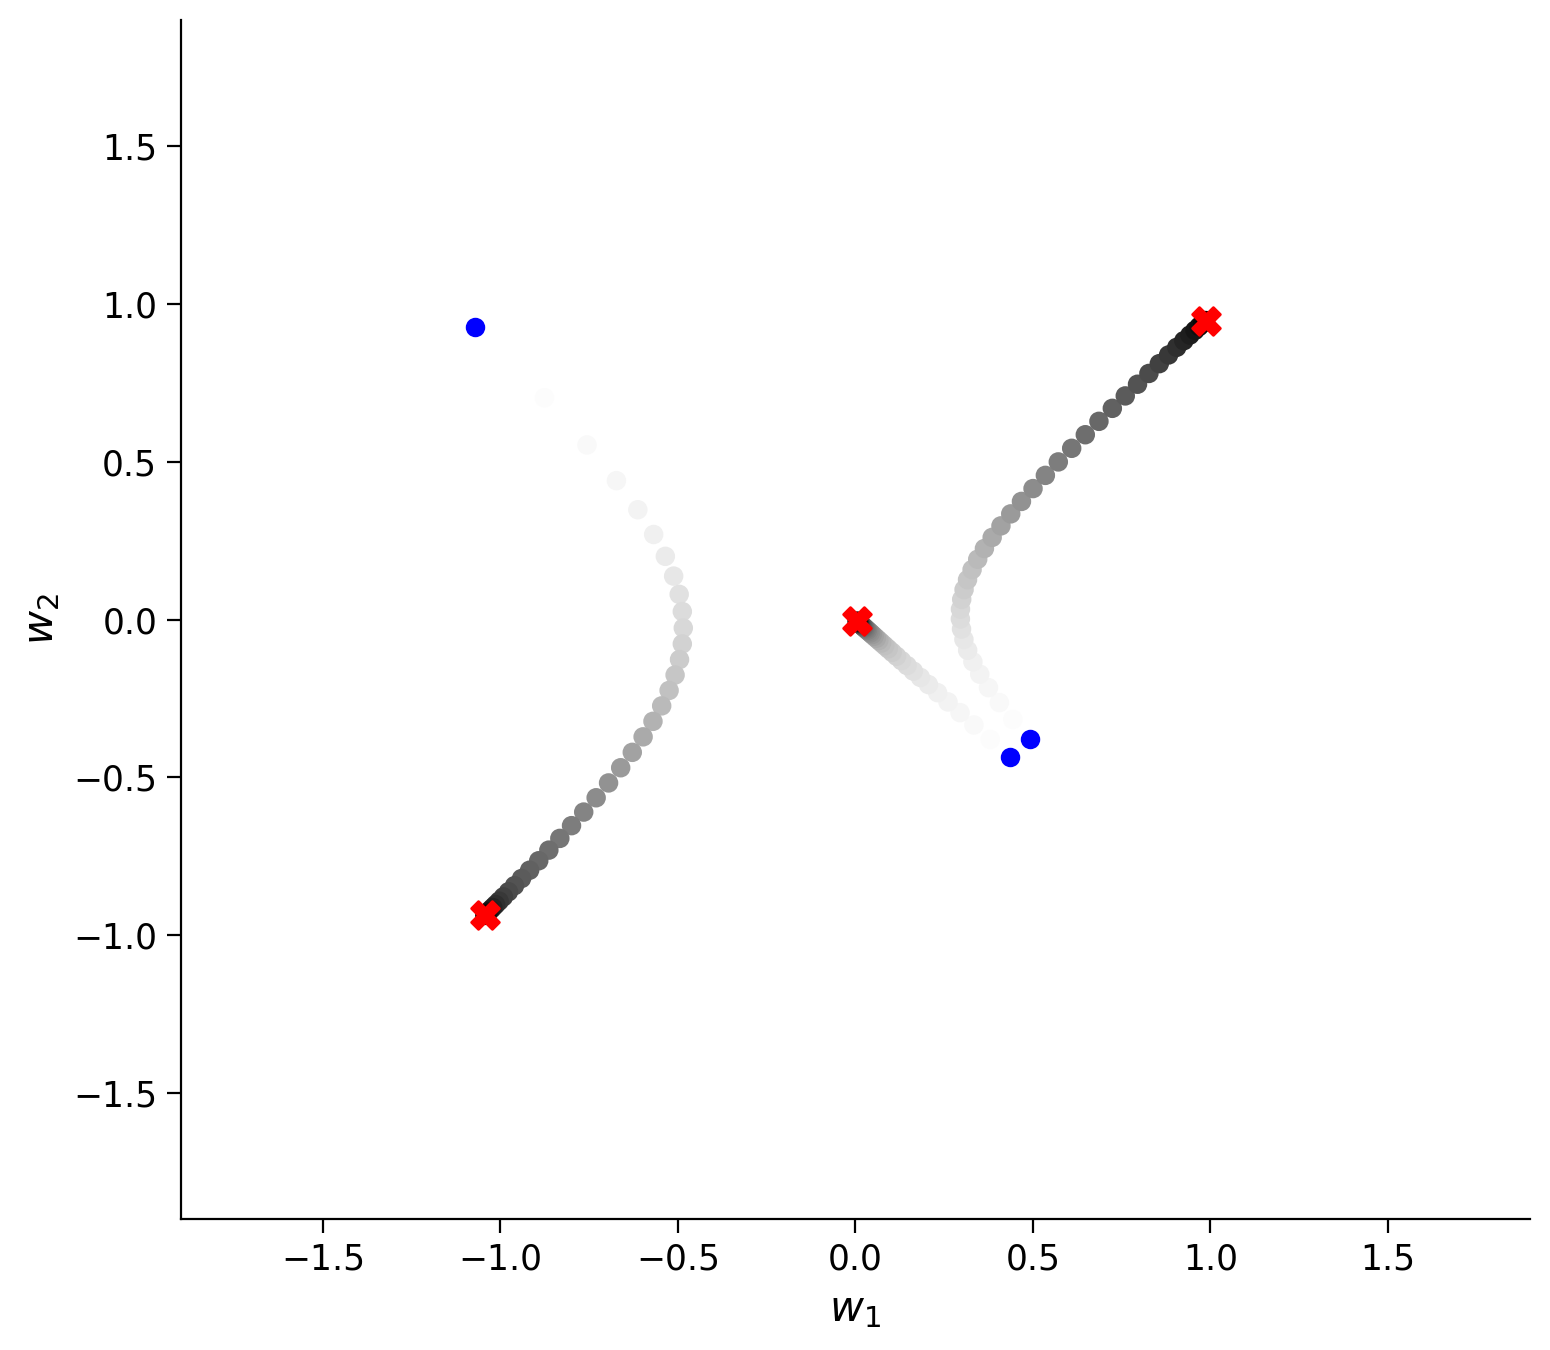

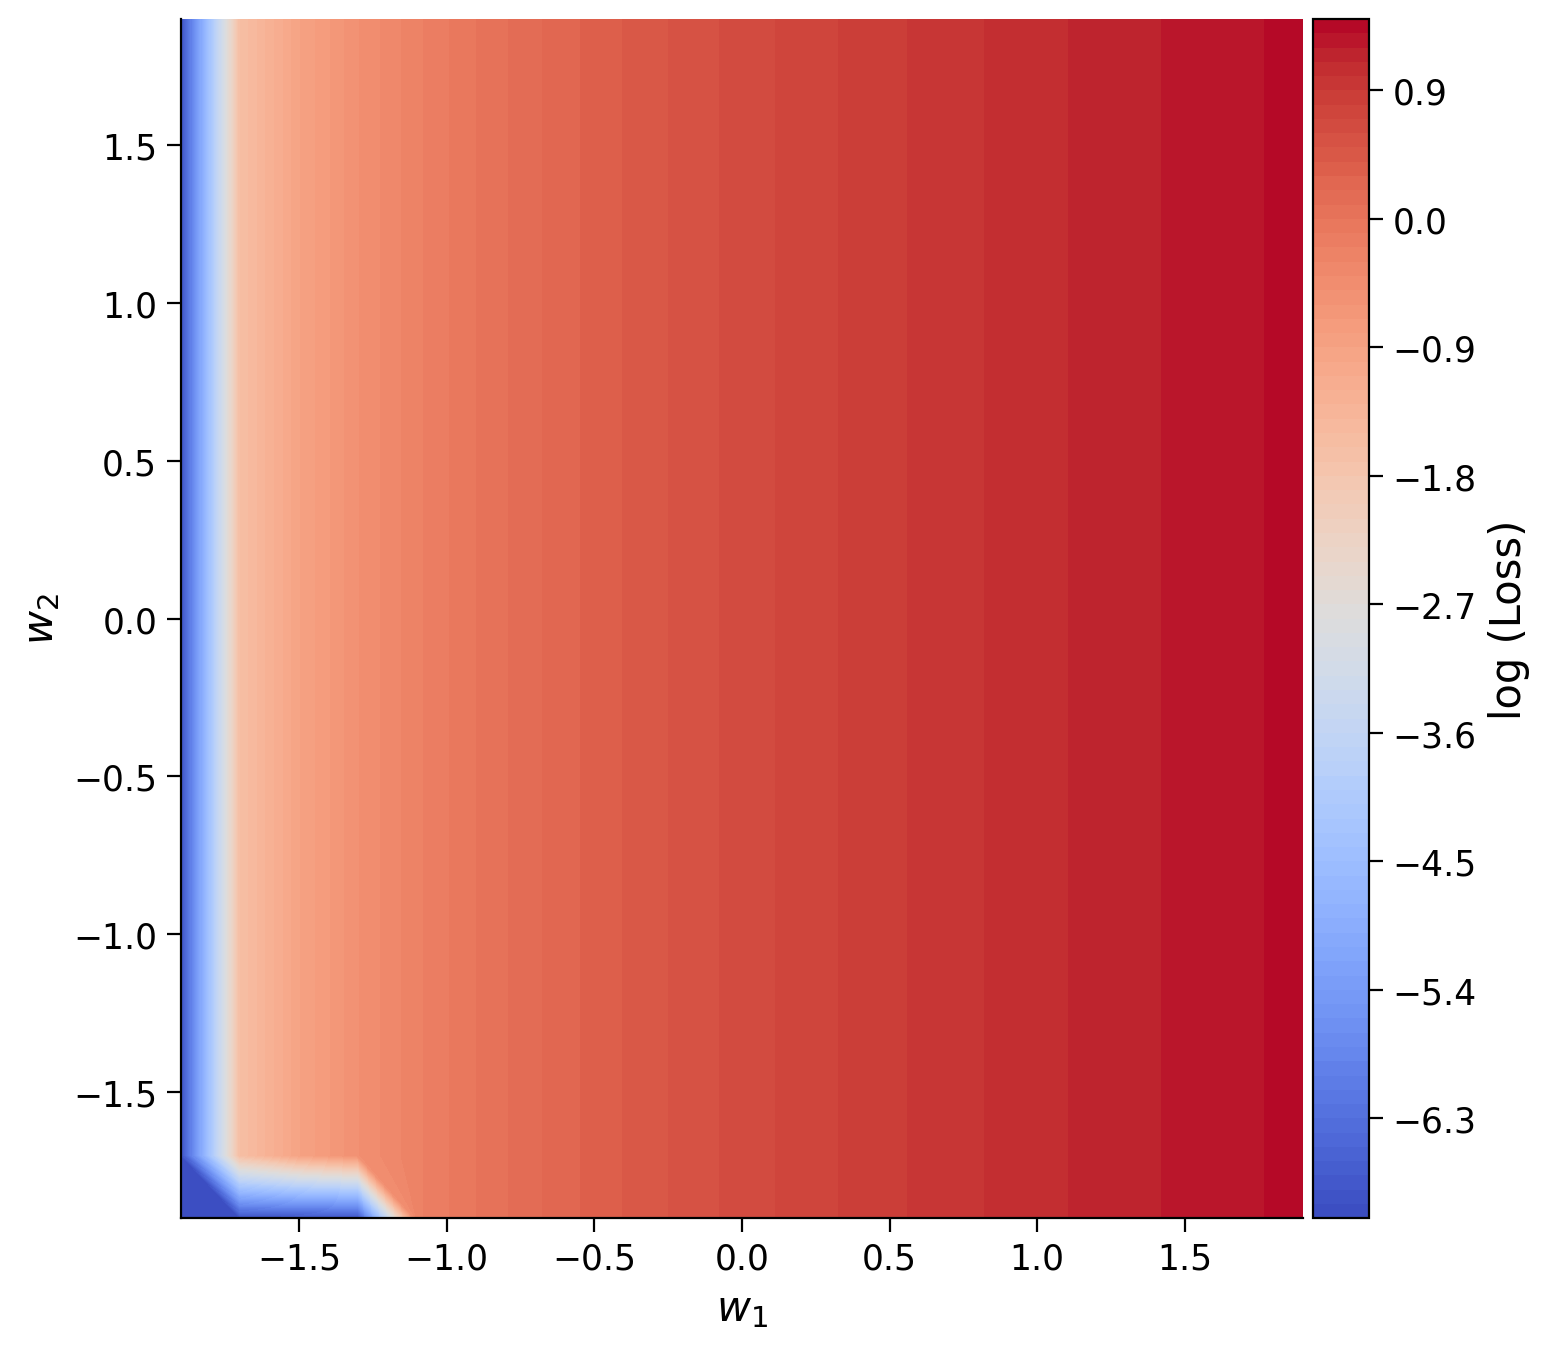

In [33]:
plot_vector_field('vectors') # For vector field
plot_vector_field('trajectory') # For trajectory
plot_vector_field('loss') # For loss counter

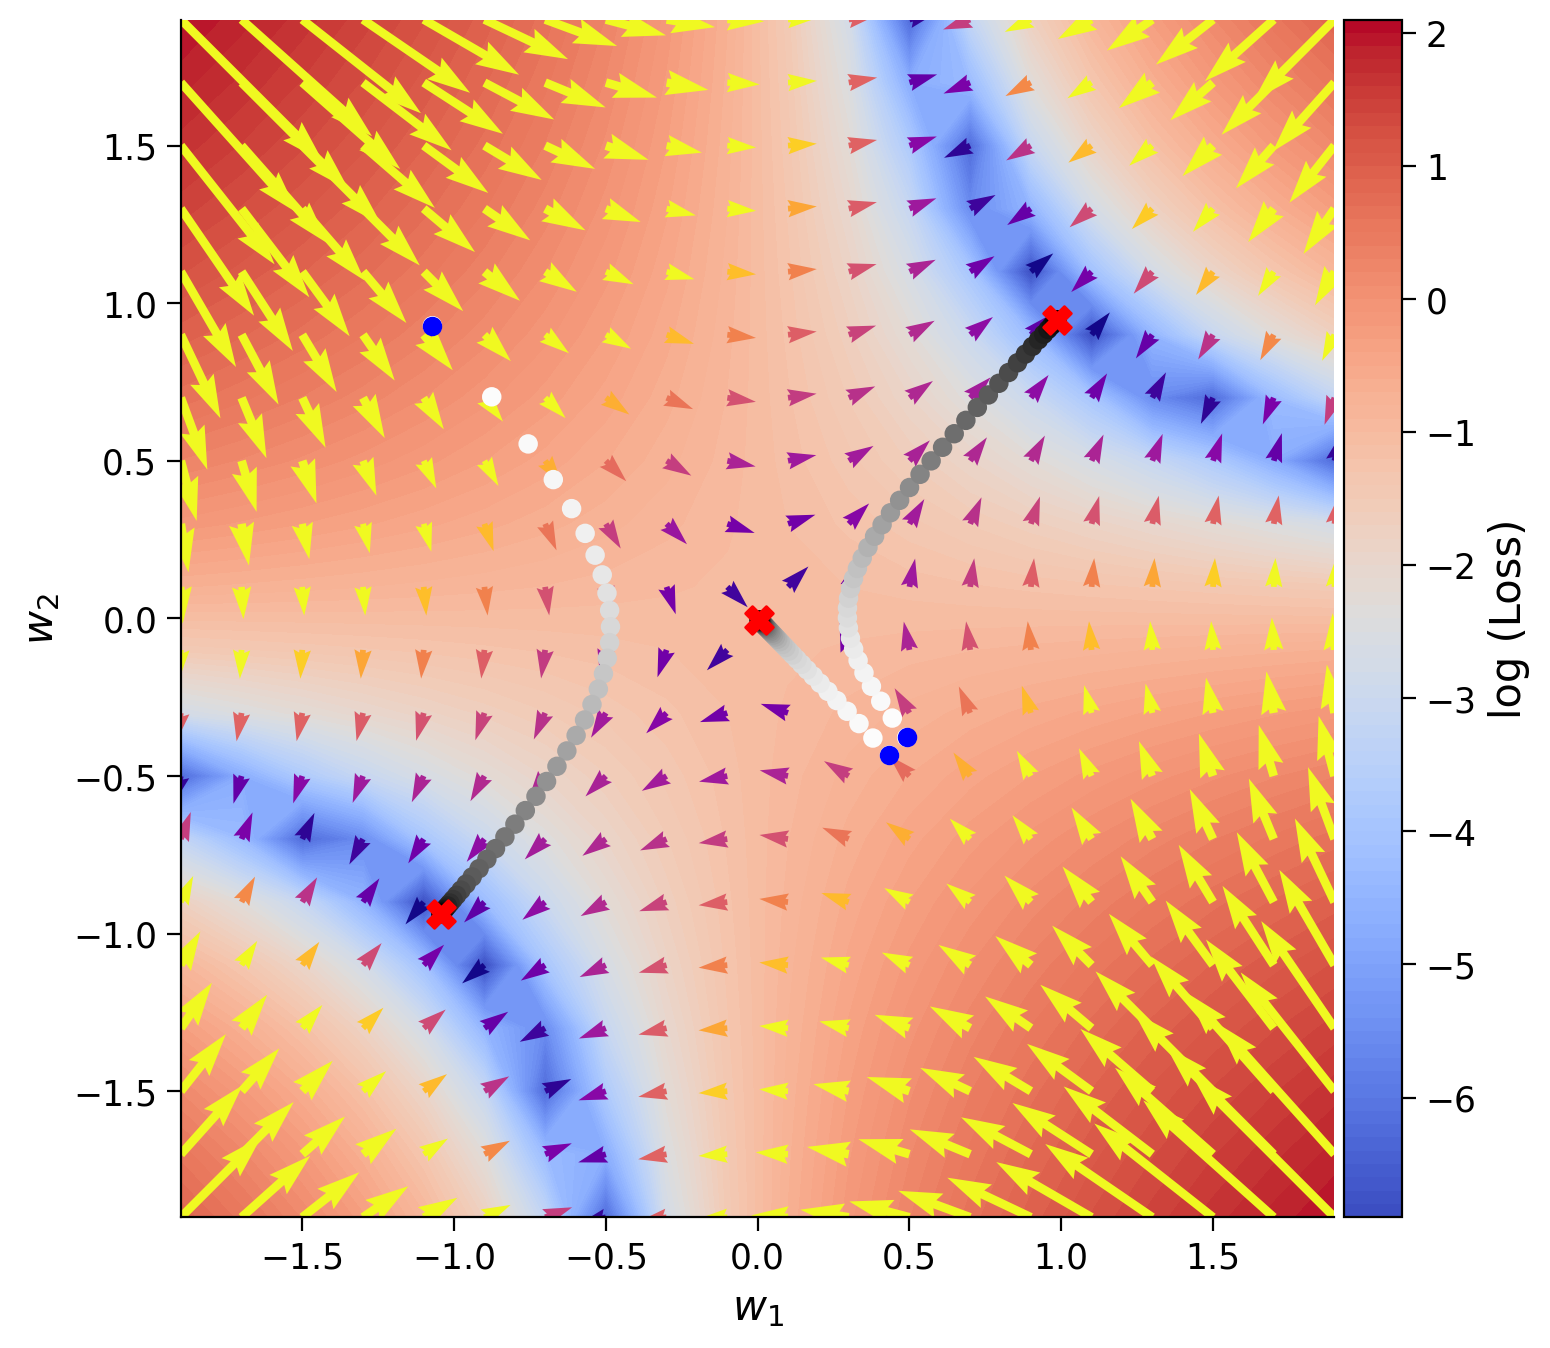

In [34]:
plot_vector_field('all')

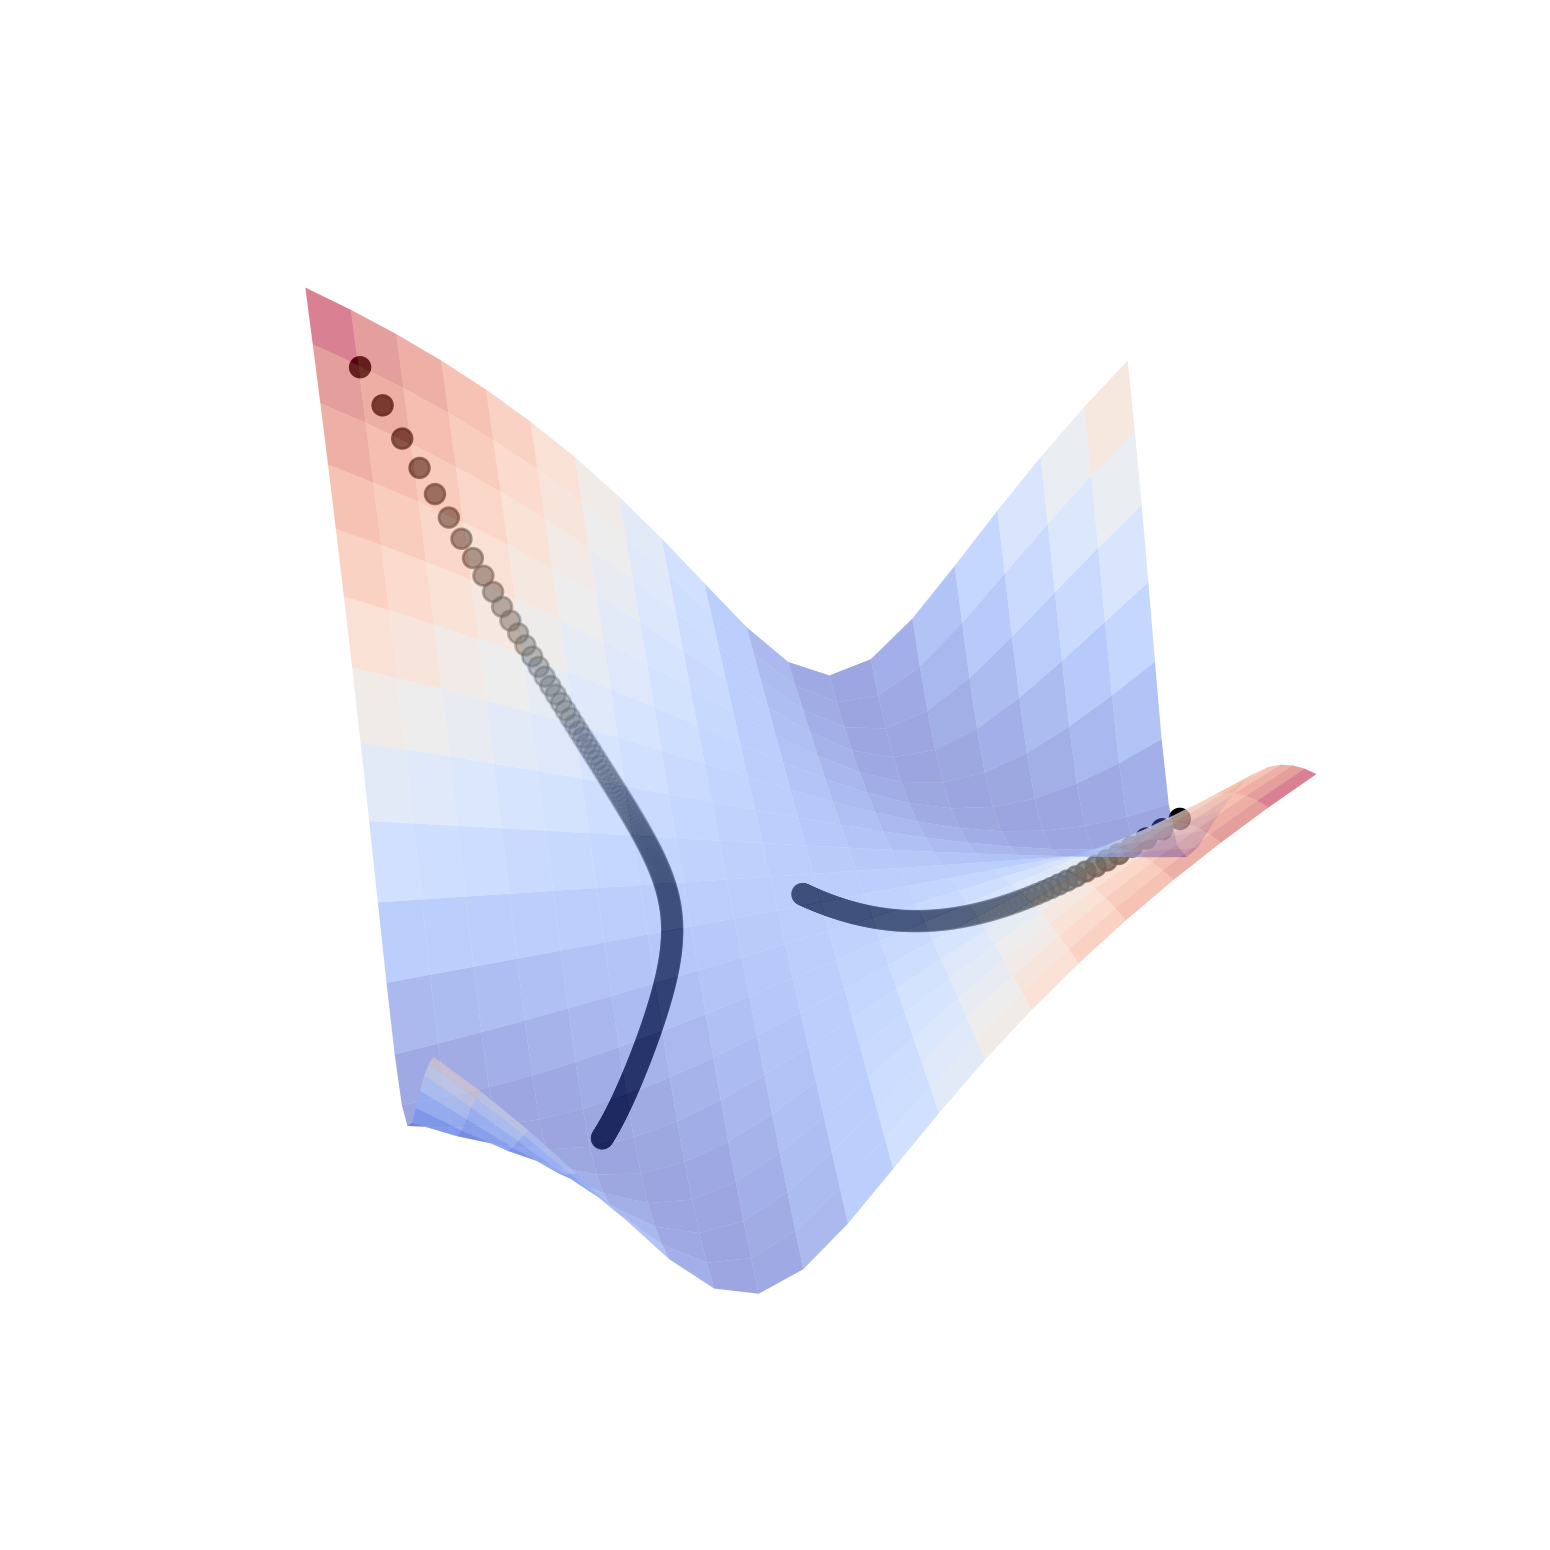

In [35]:
plot_loss_landscape()

In [36]:
depth_widget

<function __main__.depth_widget(depth)>

In [37]:
# @markdown Make sure you execute this cell to enable the widget!

_ = interact(depth_widget,
             depth=IntSlider(min=0,
                             max=51,
                             step=5,
                             value=0,
                             continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=51, step=5), Output…

In [38]:
# @markdown Make sure you execute this cell to enable the widget!

In [39]:
_ = interact(lr_widget,
             lr=FloatSlider(min=0.005, max=0.045, step=0.005, value=0.005,
                            continuous_update=False, readout_format='.3f',
                            description='eta'))

interactive(children=(FloatSlider(value=0.005, continuous_update=False, description='eta', max=0.045, min=0.00…

# Make sure you execute the next cell to enable the widget!

In [40]:
intpl_obj = InterPlay()

intpl_obj.slider = FloatSlider(min=0.005, max=0.105, step=0.005, value=0.005,
                               layout=Layout(width='500px'),
                               continuous_update=False,
                               readout_format='.3f',
                               description='eta')

intpl_obj.button = ToggleButton(value=intpl_obj.converged, description='Register')

widgets_ui = HBox([intpl_obj.slider, intpl_obj.button])
widgets_out = interactive_output(intpl_obj.train,
                                 {
                                     'lr': intpl_obj.slider,
                                     'update': intpl_obj.button,
                                     'init_weights': fixed(0.9)
                                 })

display(widgets_ui, widgets_out)

Output()

# Make sure you execute this cell to see the figure!

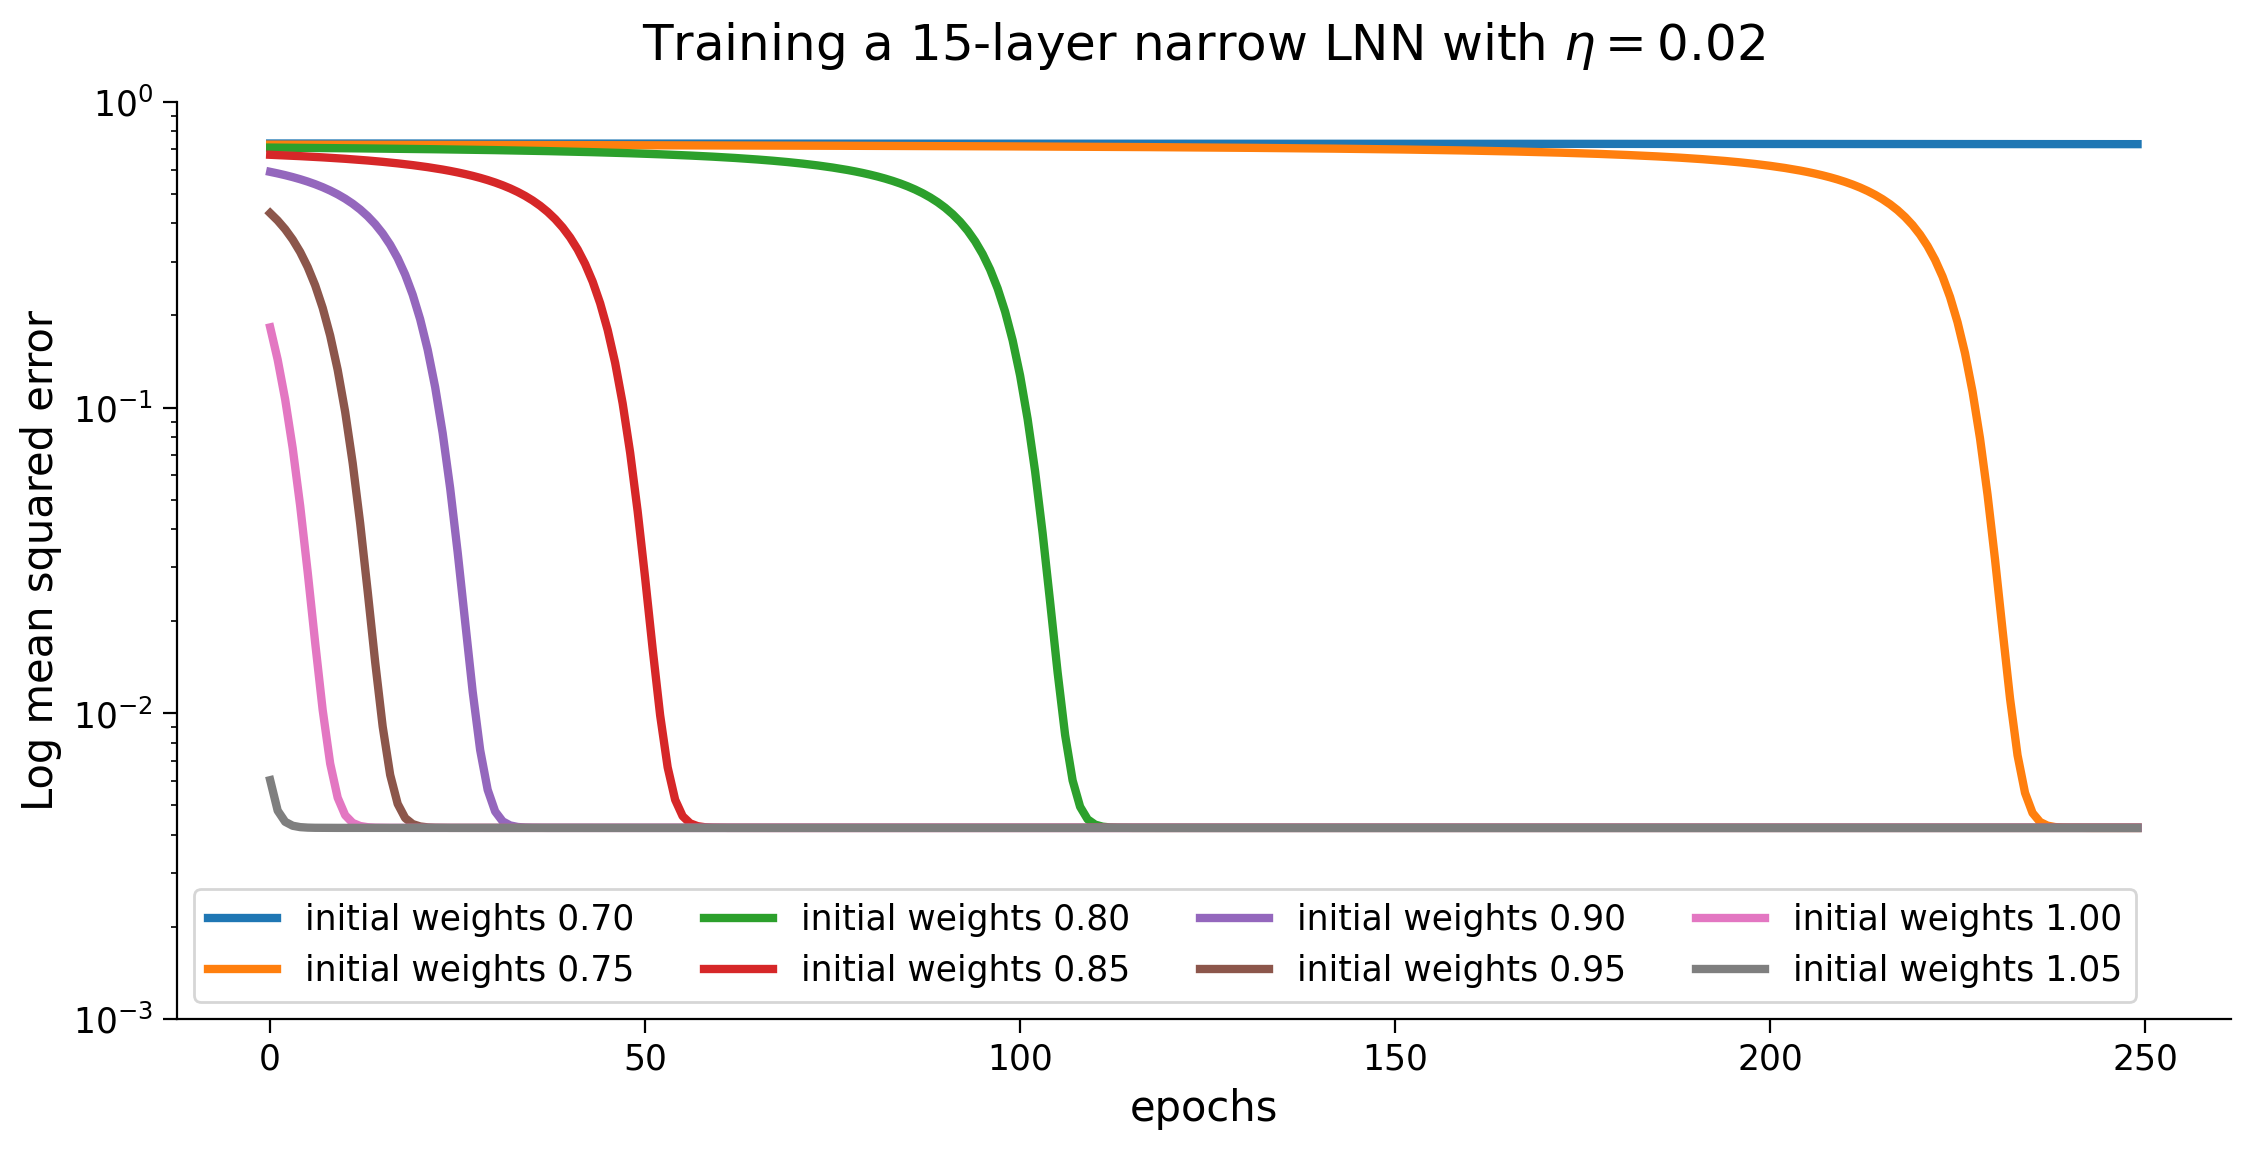

In [41]:
plot_init_effect()

In [42]:

depth = IntSlider(min=10, max=51, step=5, value=25,
                  continuous_update=False)

lr = FloatSlider(min=0.001, max=0.1, step=0.005,
                 value=0.005, continuous_update=False,
                 readout_format='.3f', description='eta')

init_weights = FloatSlider(min=0.1, max=3.0,
                           step=0.1, value=0.9,
                           continuous_update=False,
                           readout_format='.3f',
                           description='initial weights')

_ = interact(depth_lr_init_interplay,
             depth=depth,
             lr=lr,
             init_weights=init_weights)

interactive(children=(IntSlider(value=25, continuous_update=False, description='depth', max=51, min=10, step=5…

# Install and import feedback gadget

In [59]:
# Imports
import math
import torch
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

In [60]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from matplotlib import gridspec
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import FloatLogSlider, Layout, VBox
from ipywidgets import interactive_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

# Plotting functions

In [61]:
# @title Plotting functions

def plot_x_y_hier_data(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for all samples

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of all samples")
  ax1.set_title("Features of all samples")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_x_y_hier_one(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for a single sample

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 1))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of a single sample")
  ax1.set_title("Features of a single sample")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_tree_data(label_list = None, feature_array = None, new_feature = None):
  """
  Plot tree data

  Args:
    label_list: np.ndarray
      List of labels [default: None]
    feature_array: np.ndarray
      List of features [default: None]
    new_feature: string
      Enables addition of new features

  Returns:
    Nothing
  """
  cmap = matplotlib.colors.ListedColormap(['cyan', 'magenta'])
  n_features = 10
  n_labels = 8
  im1 = np.eye(n_labels)
  if feature_array is None:
    im2 = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 1],
                      [0, 0, 1, 1, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 1]]).T
    im2[im2 == 0] = -1
    feature_list = ['can_grow',
                    'is_mammal',
                    'has_leaves',
                    'can_move',
                    'has_trunk',
                    'can_fly',
                    'can_swim',
                    'has_stem',
                    'is_warmblooded',
                    'can_flower']
  else:
    im2 = feature_array
  if label_list is None:
    label_list = ['Goldfish', 'Tuna', 'Robin', 'Canary',
                  'Rose', 'Daisy', 'Pine', 'Oak']
  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.35])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax1.imshow(im1, cmap=cmap)
  if feature_array is None:
    implt = ax2.imshow(im2, cmap=cmap, vmin=-1.0, vmax=1.0)
  else:
    implt = ax2.imshow(im2[:, -n_features:], cmap=cmap, vmin=-1.0, vmax=1.0)
  divider = make_axes_locatable(ax2)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(implt, cax=cax, ticks=[-0.5, 0.5])
  cbar.ax.set_yticklabels(['no', 'yes'])
  ax1.set_title("Labels")
  ax1.set_yticks(ticks=np.arange(n_labels))
  ax1.set_yticklabels(labels=label_list)
  ax1.set_xticks(ticks=np.arange(n_labels))
  ax1.set_xticklabels(labels=label_list, rotation='vertical')
  ax2.set_title("{} random Features".format(n_features))
  ax2.set_yticks(ticks=np.arange(n_labels))
  ax2.set_yticklabels(labels=label_list)
  if feature_array is None:
    ax2.set_xticks(ticks=np.arange(n_features))
    ax2.set_xticklabels(labels=feature_list, rotation='vertical')
  else:
    ax2.set_xticks(ticks=[n_features-1])
    ax2.set_xticklabels(labels=[new_feature], rotation='vertical')
  plt.tight_layout()
  plt.show()


def plot_loss(loss_array,
              title="Training loss (Mean Squared Error)",
              c="r"):
  """
  Plot loss function

  Args:
    c: string
      Specifies plot color
    title: string
      Specifies plot title
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()


def plot_loss_sv(loss_array, sv_array):
  """
  Plot loss function

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("Set1", n_sing_values)

  _, (plot1, plot2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
  plot1.set_title("Training loss (Mean Squared Error)")
  plot1.plot(loss_array, color='r')

  plot2.set_title("Evolution of singular values (modes)")
  for i in range(n_sing_values):
    plot2.plot(sv_array[:, i], c=cmap(i))
  plot2.set_xlabel("Epoch")
  plt.show()


def plot_loss_sv_twin(loss_array, sv_array):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Learning Dynamics")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(loss_array, color='r')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_ills_sv_twin(ill_array, sv_array, ill_label):
  """
  Plot network training evolution
  and illusory correlations

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    ill_array: np.ndarray
      Log of illusory correlations per epoch
    ill_label: np.ndarray
      Log of labels associated with illusory correlations

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Network training and the Illusory Correlations")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel(ill_label, c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(ill_array, color='r', linewidth=3)
  ax1.set_ylim(-1.05, 1.05)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_loss_sv_rsm(loss_array, sv_array, rsm_array, i_ep):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch
    rsm_array: torch.tensor
      Representation similarity matrix
    i_ep: int
      Which epoch to show

  Returns:
    Nothing
  """
  n_ep = loss_array.shape[0]
  rsm_array = rsm_array / np.max(rsm_array)
  sv_array = sv_array / np.max(sv_array)

  n_sing_values = sv_array.shape[1]
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(14, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=[5, 3])

  ax0 = plt.subplot(gs[1])
  ax0.yaxis.tick_right()
  implot = ax0.imshow(rsm_array[i_ep], cmap="Purples", vmin=0.0, vmax=1.0)
  divider = make_axes_locatable(ax0)
  cax = divider.append_axes("right", size="5%", pad=0.9)
  cbar = plt.colorbar(implot, cax=cax, ticks=[])
  cbar.ax.set_ylabel('Similarity', fontsize=12)
  ax0.set_title("RSM at epoch {}".format(i_ep), fontsize=16)
  ax0.set_yticks(ticks=np.arange(n_sing_values))
  ax0.set_yticklabels(labels=item_names)
  ax0.set_xticks(ticks=np.arange(n_sing_values))
  ax0.set_xticklabels(labels=item_names, rotation='vertical')

  ax1 = plt.subplot(gs[0])
  ax1.set_title("Learning Dynamics", fontsize=16)
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r', direction="in")
  ax1.plot(np.arange(n_ep), loss_array, color='r')
  ax1.axvspan(i_ep-2, i_ep+2, alpha=0.2, color='m')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values", c='b')
  ax2.tick_params(axis='y', labelcolor='b', direction="in")
  for i in range(n_sing_values):
    ax2.plot(np.arange(n_ep), sv_array[:, i], c=cmap(i))
  ax1.set_xlim(-1, n_ep+1)
  ax2.set_xlim(-1, n_ep+1)

  plt.show()

# Helper functions

In [62]:
# @title Helper functions

def build_tree(n_levels, n_branches, probability,
               to_np_array=True):
  """
  Builds tree

  Args:
    n_levels: int
      Number of levels in tree
    n_branches: int
      Number of branches in tree
    probability: float
      Flipping probability
    to_np_array: boolean
      If true, represent tree as np.ndarray

  Returns:
    tree: dict if to_np_array=False
          np.ndarray otherwise
      Tree
  """
  assert 0.0 <= probability <= 1.0

  tree = {}

  tree["level"] = [0]
  for i in range(1, n_levels+1):
    tree["level"].extend([i]*(n_branches**i))

  tree["pflip"] = [probability]*len(tree["level"])

  tree["parent"] = [None]
  k = len(tree["level"])-1
  for j in range(k//n_branches):
    tree["parent"].extend([j]*n_branches)

  if to_np_array:
    tree["level"] = np.array(tree["level"])
    tree["pflip"] = np.array(tree["pflip"])
    tree["parent"] = np.array(tree["parent"])

  return tree


def sample_from_tree(tree, n):
  """
  Generates n samples from a tree

  Args:
    tree: np.ndarray/dictionary
      Tree
    n: int
      Number of levels in tree

  Returns:
    x: np.ndarray
      Sample from tree
  """
  items = [i for i, v in enumerate(tree["level"]) if v == max(tree["level"])]
  n_items = len(items)
  x = np.zeros(shape=(n, n_items))
  rand_temp = np.random.rand(n, len(tree["pflip"]))
  flip_temp = np.repeat(tree["pflip"].reshape(1, -1), n, 0)
  samp = (rand_temp > flip_temp) * 2 - 1

  for i in range(n_items):
    j = items[i]
    prop = samp[:, j]
    while tree["parent"][j] is not None:
      j = tree["parent"][j]
      prop = prop * samp[:, j]
    x[:, i] = prop.T
  return x


def generate_hsd():
  """
  Building the tree

  Args:
    None

  Returns:
    tree_labels: np.ndarray
      Tree Labels
    tree_features: np.ndarray
      Sample from tree
  """
  n_branches = 2  # 2 branches at each node
  probability = .15  # flipping probability
  n_levels = 3  # number of levels (depth of tree)
  tree = build_tree(n_levels, n_branches, probability, to_np_array=True)
  tree["pflip"][0] = 0.5
  n_samples = 10000 # Sample this many features

  tree_labels = np.eye(n_branches**n_levels)
  tree_features = sample_from_tree(tree, n_samples).T
  return tree_labels, tree_features


def linear_regression(X, Y):
  """
  Analytical Linear regression

  Args:
    X: np.ndarray
      Input features
    Y: np.ndarray
      Targets

  Returns:
    W: np.ndarray
      Analytical solution
      W = Y @ X.T @ np.linalg.inv(X @ X.T)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dx == Dy
  W = Y @ X.T @ np.linalg.inv(X @ X.T)
  return W


def add_feature(existing_features, new_feature):
  """
  Adding new features to existing tree

  Args:
    existing_features: np.ndarray
      List of features already present in the tree
    new_feature: list
      List of new features to be added

  Returns:
    New features augmented with existing features
  """
  assert isinstance(existing_features, np.ndarray)
  assert isinstance(new_feature, list)
  new_feature = np.array([new_feature]).T
  return np.hstack((tree_features, new_feature))


def net_svd(model, in_dim):
  """
  Performs a Singular Value Decomposition on
  given model weights

  Args:
    model: torch.nn.Module
      Neural network model
    in_dim: int
      The input dimension of the model

  Returns:
    U: torch.tensor
      Orthogonal Matrix
    Σ: torch.tensor
      Diagonal Matrix
    V: torch.tensor
      Orthogonal Matrix
  """
  W_tot = torch.eye(in_dim)
  for weight in model.parameters():
    W_tot = weight.detach() @ W_tot
  U, SIGMA, V = torch.svd(W_tot)
  return U, SIGMA, V


def net_rsm(h):
  """
  Calculates the Representational Similarity Matrix

  Args:
    h: torch.Tensor
      Activity of a hidden layer

  Returns:
    rsm: torch.Tensor
      Representational Similarity Matrix
  """
  rsm = h @ h.T
  return rsm


def initializer_(model, gamma=1e-12):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=sigma)


def test_initializer_ex(seed):
  """
  Testing initializer implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(5000, 5000, 1)
  try:
    ex_initializer_(model, gamma=1)
    std = torch.std(next(iter(model.parameters())).detach()).item()
    if -1e-5 <= (std - 0.01) <= 1e-5:
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_svd_ex(seed):
  """
  Tests net_svd_ex exercise

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(8, 30, 100)
  try:
    U_ex, Σ_ex, V_ex = ex_net_svd(model, 8)
    U, Σ, V = net_svd(model, 8)
    if (torch.all(torch.isclose(U_ex.detach(), U.detach(), atol=1e-6)) and
        torch.all(torch.isclose(Σ_ex.detach(), Σ.detach(), atol=1e-6)) and
        torch.all(torch.isclose(V_ex.detach(), V.detach(), atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_rsm_ex(seed):
  """
  Tests net_rsm_ex implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  x = torch.rand(7, 17)
  try:
    y_ex = ex_net_rsm(x)
    y = x @ x.T
    if (torch.all(torch.isclose(y_ex, y, atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")

# Set random seed

# Executing `set_seed(seed=seed)` you are seeting the seed


In [63]:
# For DL it is critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# Set device (GPU or CPU). Execute `set_device`

In [64]:
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if device != 'cuda':
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [65]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [66]:
class LNNet(nn.Module):
  """
  A Linear Neural Net with one hidden layer
  """
  def __init__(self, in_dim, hid_dim, out_dim):
    """
    Initiailise LNNet parameters

    Args:
      in_dim: int
        Input dimension
      out_dim: int
        Output dimension
      hid_dim: int
        Hidden dimension

    Returns:
      Nothing
    """
    super(LNNet, self).__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)

  def forward(self, x):
    """
    Forward pass of LNNet

    Args:
      x: torch.Tensor
        Input tensor

    Returns:
      hid: torch.Tensor
        Hidden layer activity
      out: torch.Tensor
        Output/Prediction
    """
    hid = self.in_hid(x) # Hidden activity
    out = self.hid_out(hid) # Output (prediction)
    return out, hid

In [87]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """
  Training function

  Args:
    model: torch.nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate
    illusory_i: int
      Index of illusory feature

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
    modes: np.ndarray
      Record (evolution) of singular values (dynamic modes)
    rs_mats: np.ndarray
      Record (evolution) of representation similarity matrices
    illusions: np.ndarray
      Record of network prediction for the last feature
  """
  in_dim = inputs.size(1)
  losses = np.zeros(n_epochs) # Loss records
  modes = np.zeros((n_epochs, in_dim)) # Singular values (modes) records
  rs_mats = [] # Representational similarity matrices
  illusions = np.zeros(n_epochs) # Prediction for the given feature

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Section 2 Singular value decomposition
    U, Σ, V = net_svd(model, in_dim)

    # Section 3 calculating representational similarity matrix
    RSM = net_rsm(hiddens.detach())

    # Section 4 network prediction of illusory_i inputs for the last feature
    pred_ij = predictions.detach()[illusory_i, -1]

    # Logging (recordings)
    losses[i] = loss.item()
    modes[i] = Σ.detach().numpy()
    rs_mats.append(RSM.numpy())
    illusions[i] = pred_ij.numpy()

  return losses, modes, np.array(rs_mats), illusions

In [93]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """
  Training function

  Args:
    model: torch nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate
    illusory_i: int
      Index of illusory feature

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
    modes: np.ndarray
      Record (evolution) of singular values (dynamic modes)
    rs_mats: np.ndarray
      Record (evolution) of representational similarity matrices
    illusions: np.ndarray
      Record of network prediction for the last feature
  """
  in_dim = inputs.size(1)

  losses = np.zeros(n_epochs)  # Loss records
  modes = np.zeros((n_epochs, in_dim))  # Singular values (modes) records
  rs_mats = []  # Representational similarity matrices
  illusions = np.zeros(n_epochs)  # Prediction for the given feature

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Section 2 Singular value decomposition
    U, Σ, V = net_svd(model, in_dim)

    # Section 3 calculating representational similarity matrix
    RSM = net_rsm(hiddens.detach())

    # Section 4 network prediction of illusory_i inputs for the last feature
    pred_ij = predictions.detach()[illusory_i, -1]

    # Logging (recordings)
    losses[i] = loss.item()
    modes[i] = Σ.detach().numpy()
    rs_mats.append(RSM.numpy())
    illusions[i] = pred_ij.numpy()

  return losses, modes, np.array(rs_mats), illusions

In [94]:
def ex_initializer_(model, gamma=1e-12):
  """
  In-place Re-initialisation of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialisation scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=sigma)


In [95]:
test_initializer_ex(SEED)

Well done! Seems to be correct!


In [96]:
torch.manual_seed(SEED)
model = LNNet(5000, 5000, 1)
ex_initializer_(model, gamma=1)
std = torch.std(next(iter(model.parameters())).detach()).item()
print(std)

0.009999624453485012


#### Run to generate and visualize training samples from tree

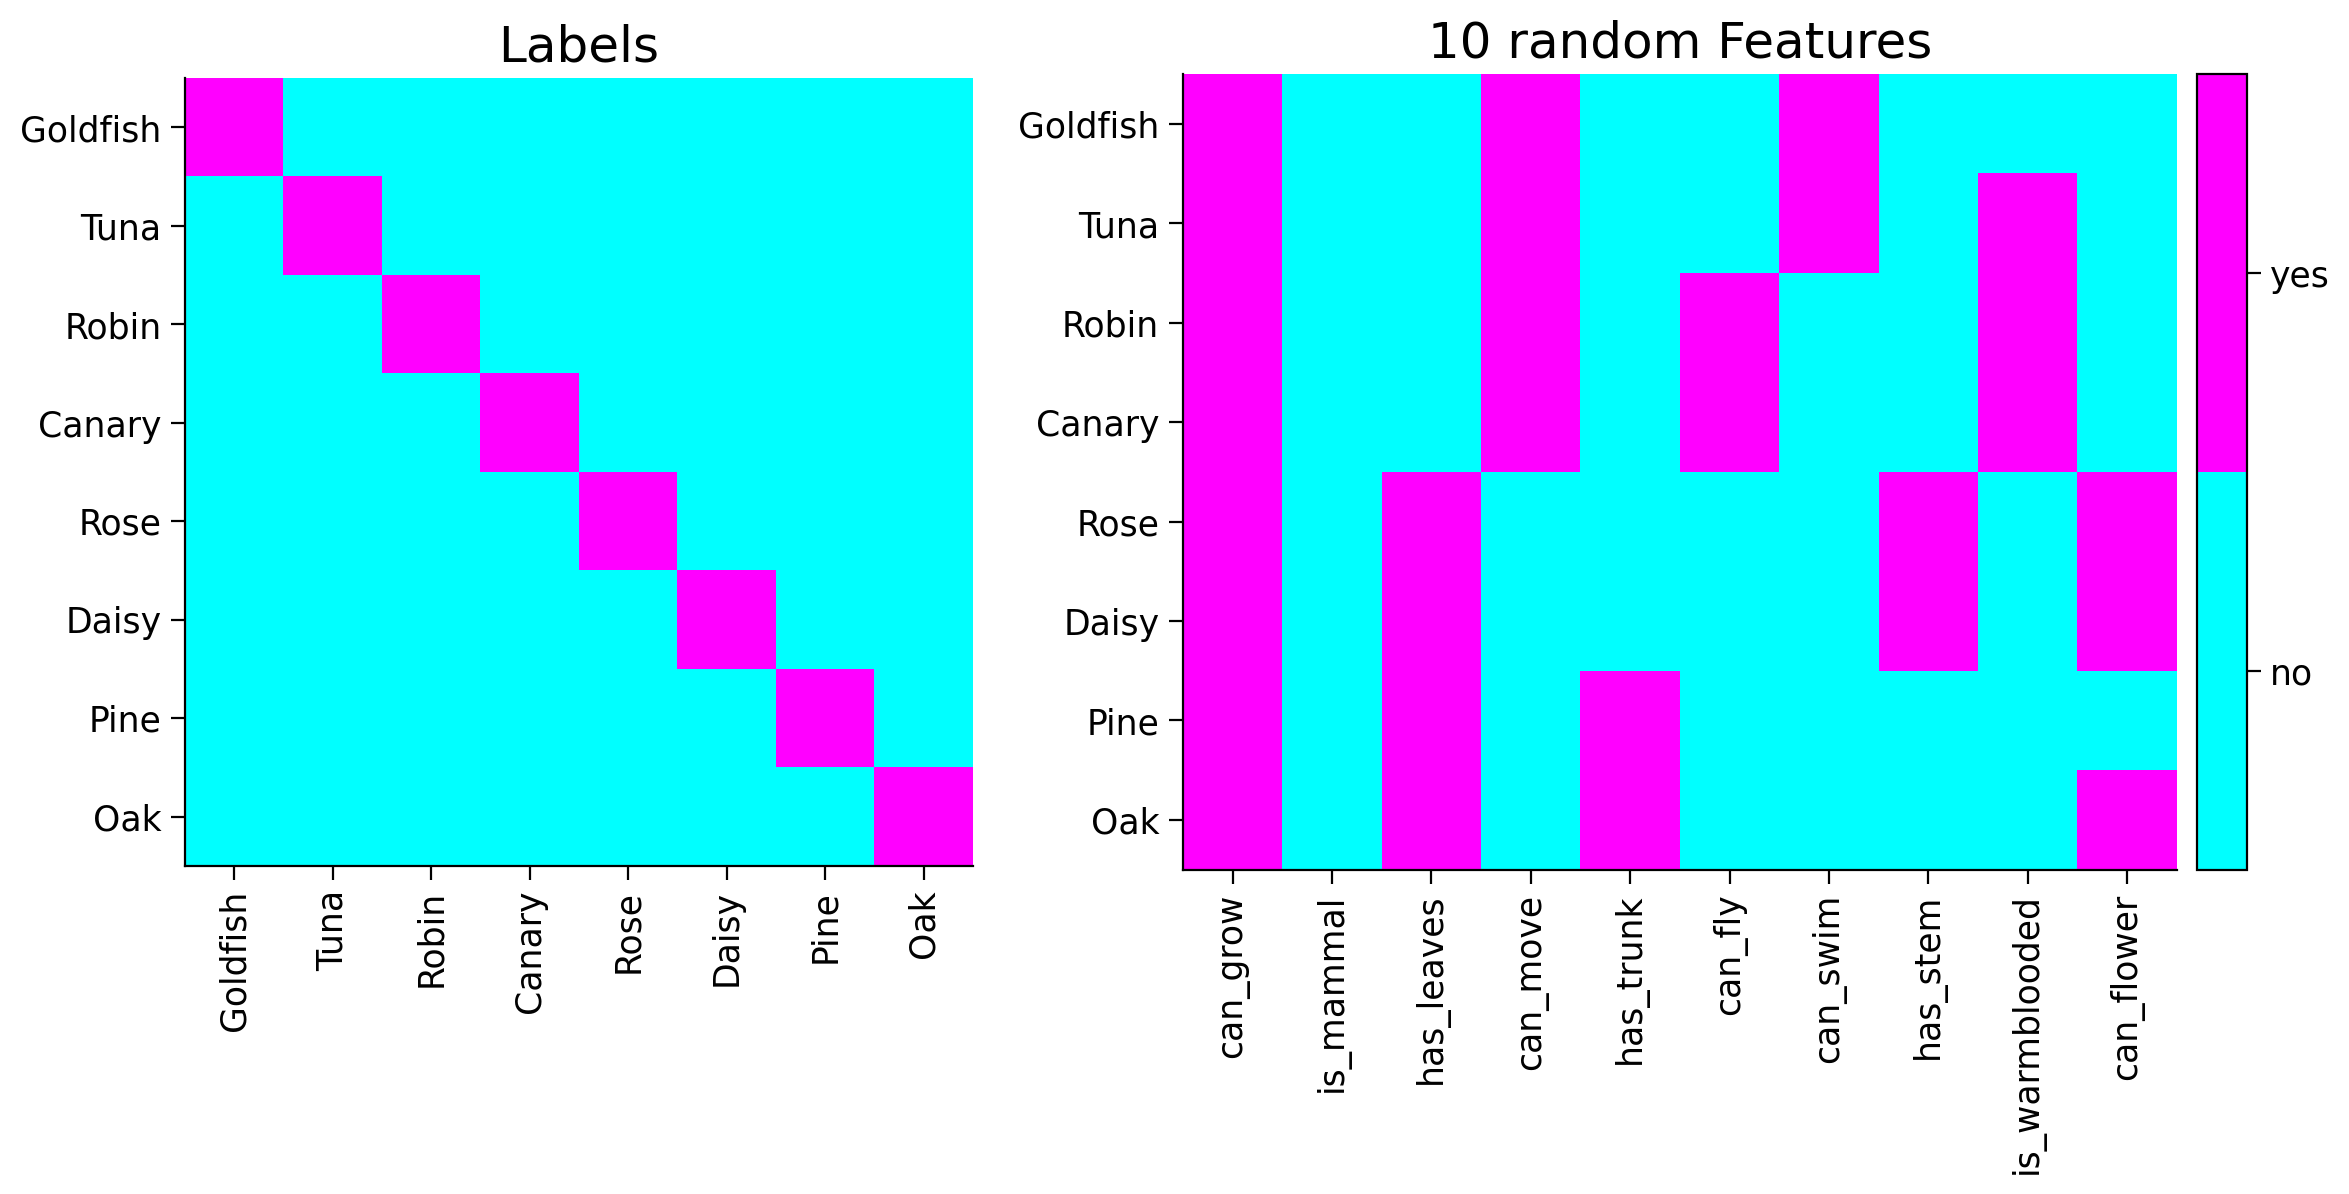

-------------------------------------------------------------------------
Input Dimension:  8
Output Dimension: 10000
Number of Samples: 8
Feature tensor: torch.Size([8, 10000])
Label tensor: torch.Size([8, 8])
-------------------------------------------------------------------------


In [97]:
tree_labels, tree_features = generate_hsd()

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

item_names = ['Goldfish', 'Tuna', 'Robin' 'Canary', 'Rose', 'Daisy', 'Pine', 'Oak']

plot_tree_data()

# Dimensions
print("-------------------------------------------------------------------------")
print(f"Input Dimension:  {tree_labels.shape[1]}")
print(f"Output Dimension: {tree_features.shape[1]}")
print(f"Number of Samples: {tree_features.shape[0]}")
print(f"Feature tensor: {feature_tensor.shape}")
print(f"Label tensor: {label_tensor.shape}")
print("-------------------------------------------------------------------------")

# Interactive Demo 1: Training the deep LNN

Training a neural net on our data is straight forward. Bu before executing the next cell, remember the training loss curve from the previous tutorial.

## Make sure you execute the next cell to train the neural network and plot

In [99]:
lr = 100.0 # Learning rate
gamma = 1e-12 # Initialization scale
n_epochs = 250 # Number of epochs
dim_input = label_tensor.size(1) # Input dimension = label_tensor.size(1)
dim_hidden = 30 # Hidden neurons
dim_output = feature_tensor.size(1) # Output dimension = feature_tensor.size(1)

print(f"dim_input: {dim_input}")
print(f"dim_hidden: {dim_hidden}")
print(f"dim_output: {dim_output}")

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training


dim_input: 8
dim_hidden: 30
dim_output: 10000
